# Modelling

Here I use SVD to decompose the matrix of stock changes into 2 matrices: a stocks matrix and a days matrix. This gives me a matrix, 100 x days, where each day is described by 100 factors; and another matrix, stocks x 100, where each company is described by 100 factors.    
The change in value on each day is the cumulative interaction between all these factors.    
I try this on the matrix of relative stock changes but with worse results; I go forward with the previous matrices.    
      
KNN      
Next I try using KNN to make predictions by finding similar occurences of factors. The results, as somewhat expected, aren't good. Taking a weighted average of nearest points in K-space only looks one day back to try to make a prediction. What might have a better chance is if we could identify similar paths -linking days up- in K-space. But that's beyond the scope of this project.    
-Or for each day I could add the preceeding days factors into the matrix? However this would increase the number of dimensions by the multiple of the number of days: add the 4 preceding days -500 dimensions for KNN

I then go from considering every factor for single days to looking at all days for single factors.     

LSTMs:   
After some hyperparameter tuning on an initial model, I found I got better results with the model I use in my Comparison notebook. With more time I'd like to use this model as a basis for tuning.   

I go on to make predictions for the next day, and also for a range of days into the future.   
I transform the results to compare them with those from the Comparison Notebook.    

Lastly I rebuild the Stock-Dates matrix using the predicted values and test their accuracy

In [90]:
import pandas as pd
import numpy as np
import math
import random
from datetime import date, timedelta

from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate as CV
from surprise.model_selection import GridSearchCV as GSCV
from surprise.model_selection import train_test_split as TTS
from surprise.prediction_algorithms import SVD, SVDpp
from surprise.accuracy import rmse, mae, fcp
from surprise import dump

from sklearn.neighbors import NearestNeighbors as NN
from sklearn.preprocessing import StandardScaler as SS
from sklearn.preprocessing import MinMaxScaler as MMS
from sklearn.metrics import mean_squared_error as MSE
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Nadam

import talos

np.seed = 42

Note:   
Try also:     
biased = False   
SVD++ -but probably worse    

## SVD
SVD on the value-change data

In [2]:
df = pd.read_csv('change.csv', index_col=0)
df.head()

,A,AA,AAIC,AAN,AAP,AAT,AB,ABB,ABBV,ABC,...,ZBH,ZEN,ZEPP,ZIM,ZNH,ZTO,ZTR,ZTS,ZUO,ZYME
1999-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-11-02,NaN,NaN,9.078036e-01,NaN,NaN,NaN,0.584562,NaN,NaN,-0.074989,...,NaN,NaN,NaN,NaN,-0.137476,NaN,1.529372e-02,NaN,NaN,NaN
1999-11-03,NaN,NaN,3.080048e-01,NaN,NaN,NaN,0.127873,NaN,NaN,-0.203259,...,NaN,NaN,NaN,NaN,0.086303,NaN,-1.056488e-12,NaN,NaN,NaN
1999-11-04,NaN,NaN,8.135714e-12,NaN,NaN,NaN,0.035393,NaN,NaN,0.030588,...,NaN,NaN,NaN,NaN,0.311188,NaN,0.000000e+00,NaN,NaN,NaN
1999-11-05,NaN,NaN,7.132743e-01,NaN,NaN,NaN,0.157558,NaN,NaN,-0.036508,...,NaN,NaN,NaN,NaN,0.207459,NaN,1.056488e-12,NaN,NaN,NaN


In [3]:
def surprisify(df):
    #select over which dates to model:
    df = df.loc['2004-11-01':'2018-11-01']
    #Only select symbols of stocks with more than 100 datapoints within the dates
    syms = df.columns[df.notna().sum() > 100]
    symID = []
    dateID = []
    value = []

    for sym in syms:
        for row in df[sym].iteritems():
            if not math.isnan(row[1]):
                symID.append(sym)
                dateID.append(row[0])
                value.append(row[1])
                
    sur_dict = {'symID': symID,
              'dateID': dateID,
              'value': value
              }
    sur_df = pd.DataFrame(sur_dict)
    sur_df = sur_df[(sur_df.value < sur_df.value.quantile(0.95)) & 
           (sur_df. value > sur_df.value.quantile(0.05))]
    sur_df = sur_df.reset_index().drop('index', axis=1)
    
    print('sur_df std:', sur_df.value.std())
    print('sur_df len:', len(sur_df))
    return sur_df

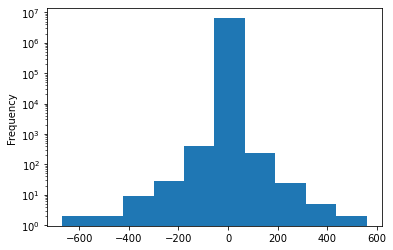

In [42]:
# Outliers were skewing the recommendations too much, so added line in surprisify to remove them
#sur_df.value.plot(kind='hist', logy=True);
#Before removal:
#Note log scale

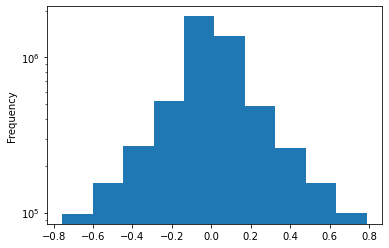

In [197]:
sur_df.value.plot(kind='hist', logy=True);
#After removal

In [4]:
def readify(df):
    ma = max(df.value)
    mi = min(df.value)
    print('ma:', ma, '\nmi:', mi)
    reader = Reader(rating_scale=(mi, ma))
    data = Dataset.load_from_df(df[['dateID', 'symID', 'value']], reader)
    return data

In [5]:
def compare(actual, preds):
    print('actual mean', np.mean(actual))
    print('pred mean', np.mean(preds))
    print('actual std', np.std(actual))
    print('pred std', np.std(preds))
    print('actual max', np.max(actual))
    print('pred max', np.max(preds))
    print('actual min', np.min(actual))
    print('pred min', np.min(preds))    


In [165]:
def svd_predict(model, testset):
    predstest = []
    for x in testset:
        predstest.append(model.predict(x[0], x[1], x[2]))
    
    actual = [x[2] for x in predstest]
    preds = [x[3] for x in predstest]
    rMSE = MSE(actual, preds, squared=False)
    MAE = mae(predstest)
    print('\nMAE:', MAE)
    print('RMSE:', rMSE)
    compare(actual,preds)
    
    return predstest

In [7]:
sur_df = surprisify(df)
data = readify(sur_df)

trainset = data.build_full_trainset()
testset = trainset.build_testset()

sur_df std: 0.24990306377419882
sur_df len: 5247952
ma: 0.7874996751812233 
mi: -0.7562565210594983


In [272]:
#param_grid = {'reg_all': [0.02, 0.1, 0.4], 'biased': [True, False]}
#param_grid = {'reg_all': [0.02, 0.01, 0.005, 0.001, 0], 'biased': [False]}
param_grid = {'reg_all': [0.005], 'biased': [False], 'n_epochs': [150], 'lr_all': [0.001]}
change_gscv = GSCV(SVD, param_grid, cv=5, refit=True, n_jobs= -1)
change_gscv.fit(data)

print(change_gscv.best_score)
print(change_gscv.best_params)
change_svd = change_gscv.best_estimator['rmse']

predstest = svd_predict(change_svd, testset)

dump.dump('models/svd/change_svd.p', algo=change_svd, predictions=predstest)

MAE:  0.1302

MAE: 0.1301742089449121
RMSE: 0.19417110143309213
actual mean 0.009576238300015201
pred mean 0.00933645363892516
actual std 0.24990303996451438
pred std 0.13503695591280598
actual max 0.7874996751812233
pred max 0.7874996751812233
actual min -0.7562565210594983
pred min -0.7562565210594983


In [ ]:
#SVDpp: takes too long for now
# param_grid = {'reg_all': [0.02, 0.1]}
# change_svdpp = GSCV(SVDpp, param_grid, cv=3, n_jobs=4, refit=True)
# change_svdpp.fit(data)

C:\Users\Maltanno\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


### SVD on relative change

In [9]:
rel_df = pd.read_csv('rel_change.csv', index_col=0)
rel_df.head()

,A,AA,AAIC,AAN,AAP,AAT,AB,ABB,ABBV,ABC,...,ZBH,ZEN,ZEPP,ZIM,ZNH,ZTO,ZTR,ZTS,ZUO,ZYME
1999-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-11-02,NaN,NaN,5.363985e-02,NaN,NaN,NaN,0.089028,NaN,NaN,-0.026601,...,NaN,NaN,NaN,NaN,-0.024616,NaN,4.726536e-03,NaN,NaN,NaN
1999-11-03,NaN,NaN,1.727273e-02,NaN,NaN,NaN,0.017883,NaN,NaN,-0.074074,...,NaN,NaN,NaN,NaN,0.015843,NaN,-3.249726e-13,NaN,NaN,NaN
1999-11-04,NaN,NaN,4.484993e-13,NaN,NaN,NaN,0.004863,NaN,NaN,0.012039,...,NaN,NaN,NaN,NaN,0.056236,NaN,0.000000e+00,NaN,NaN,NaN
1999-11-05,NaN,NaN,3.932082e-02,NaN,NaN,NaN,0.021542,NaN,NaN,-0.014198,...,NaN,NaN,NaN,NaN,0.035495,NaN,3.249726e-13,NaN,NaN,NaN


In [10]:
sur_rel_df = surprisify(rel_df)
rel_data = readify(sur_rel_df)

rel_trainset = rel_data.build_full_trainset()
rel_testset = rel_trainset.build_testset()

sur_df std: 0.010550485895147763
sur_df len: 5247953
ma: 0.0276115485559359 
mi: -0.0272549314905754


In [20]:
param_grid = {'reg_all': [0.02], 'biased': [False]}
rel_change_gscv = GSCV(SVD, param_grid, cv=5, refit=True, n_jobs= -1)
rel_change_gscv.fit(rel_data)

print(rel_change_gscv.best_score)
print(rel_change_gscv.best_params)
rel_change_svd = rel_change_gscv.best_estimator['rmse']

rel_predstest = svd_predict(rel_change_svd, rel_testset)

dump.dump('models/svd/rel_change_svd.p', algo=rel_change_svd, predictions=rel_predstest)

C:\Users\Maltanno\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'rmse': 0.010572809461804186, 'mae': 0.00814941529751569}
{'rmse': {'reg_all': 0.02, 'biased': False}, 'mae': {'reg_all': 0.02, 'biased': False}}
MAE:  0.0081

MAE: 0.008143591311586196
RMSE: 0.010566526058107546
actual mean 0.00037662949720158813
pred mean 7.164359554217163e-08
actual std 0.01056238022792759
pred std 0.00010692284978385201
actual max 0.0275121623888609
pred max 0.01437051455094787
actual min -0.0273549525700418
pred min -0.010776056463523878


The prediction seems better for the absolute change in values, I will use that going forwards.

## Proposition:
Some days are similar to others. I.e. The factors affecting stocks on one day have previously been in a similar circumstance and the stocks will change in a similar manner as how they previously did.


## KNN

Proposition:   
Some days are similar to others. I.e. The factors affecting stocks on one day have occurred previously, and the stocks will change in a similar manner as they previously did.

In [8]:
load = dump.load('models/svd/change_svd.p')
svd = load[1]

In [9]:
days_df = pd.DataFrame(svd.pu) #The decomposed days matrix
days_df.index = df.loc['2004-11-01':'2018-11-01'].index
days_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2018-10-26,-0.017681,-0.030037,0.007010,-0.056040,-0.013096,-0.043383,0.023906,-0.129754,0.125933,0.000459,...,0.023024,-0.011390,0.029439,-0.048793,-0.008432,-0.094443,0.037733,-0.121666,0.013217,0.082606
2018-10-29,-0.055015,-0.043319,-0.095077,0.173342,-0.232825,-0.033182,0.043343,-0.247955,0.094256,-0.024082,...,0.167429,-0.049667,-0.083390,-0.281474,0.147189,0.031788,0.027674,-0.176813,0.071061,0.259893
2018-10-30,0.139604,0.056668,0.050205,-0.206252,-0.133817,-0.096923,-0.055339,0.096933,-0.146488,0.152315,...,-0.174886,0.085448,0.115786,0.290035,-0.176873,-0.126516,-0.097975,0.126158,-0.083240,-0.230575
2018-10-31,0.023067,-0.099067,-0.129650,0.090341,-0.039320,0.119180,-0.001036,-0.178746,0.024153,0.020612,...,0.151266,0.055136,-0.079353,-0.131755,0.045937,-0.052744,0.130325,-0.182717,0.105395,0.148380
2018-11-01,0.050889,0.112854,0.125979,-0.191887,-0.020171,-0.211083,0.041692,0.224726,0.026027,0.084713,...,-0.149838,0.034499,0.070586,0.186385,-0.025320,-0.185937,-0.092210,0.251331,-0.138556,-0.232047


In [10]:
# Find 5 nearest neighbours of each point, with distances
ss = SS()
scaled = ss.fit_transform(days_df)

nn = NN(n_neighbors = 5)
nn.fit(scaled)
neighbours = nn.kneighbors(X=days_df)

In [14]:
def nn_pred(df, neighbours):
    #make predictions using mean of nearest neighbours, weighted by distance
    preds = {}
    for i, row in enumerate(df[1:].index):
        w_num = 1 / np.sum(1 / np.square(neighbours[0][i]))
        w_den = np.square(neighbours[0][i])
        weights = w_num / w_den
        vals = df.iloc[neighbours[1][0]-1].transpose() * weights
        preds[row] = vals.transpose().sum()
    return preds

In [15]:
def nn_results(df, ss, preds):
    preds_df = pd.DataFrame(preds).transpose()
    uns_preds = pd.DataFrame(ss.inverse_transform(preds_df), index=preds_df.index)
    
    list_preds = np.reshape(np.array(uns_preds), -1)
    list_true = np.reshape(np.array(df[1:]), -1)
    rmse = MSE(list_true, list_preds, squared=False)
    print('RMSE: ', rmse)
    compare(list_true, list_preds)
    
    print('\nBASELINE RMSE:')
    base_true = list_true[df.shape[1]:]
    base_preds = list_true[:-df.shape[1]]
    rmse = MSE(base_true, base_preds, squared=False)
    print(rmse)


In [16]:
nn_preds = nn_pred(days_df, neighbours)
nn_results(days_df, ss, nn_preds)

RMSE:  0.07515076197509442
actual mean 0.0006881582797717348
pred mean 0.0005611113859424029
actual std 0.07521758889703965
pred std 0.004896769738220742
actual max 0.4621352454220627
pred max 0.012497912357492591
actual min -0.4626614849674878
pred min -0.012829473276606086

BASELINE RMSE:
0.09862612282779348


Note: baseline here is using the previous day's value as the prediction        
Poor results (though better than previous-day baseline, barely better than the actual std):    

Too many dimensions    
Only finds similarities on the same scale    
Values cancelling when averaging   

Will try PCA

### PCA

In [17]:
pca = PCA(n_components=10)
pca_df = pd.DataFrame(pca.fit_transform(days_df))
print(np.cumsum(pca.explained_variance_ratio_))

[0.22701137 0.28899111 0.34266332 0.37899042 0.41132902 0.44006264
 0.46684546 0.49191942 0.51287295 0.53109478]


In [18]:
pca_ss = SS()
pca_scaled = pca_ss.fit_transform(pca_df)

pca_nn = NN(n_neighbors = 5)
pca_nn.fit(pca_scaled)
pca_neighbours = pca_nn.kneighbors(X=pca_df)

In [19]:
pca_preds = nn_pred(pca_df, pca_neighbours)
nn_results(pca_df, pca_ss, pca_preds)

RMSE:  0.17358031885097738
actual mean 4.540763419304706e-07
pred mean 0.006532451270089181
actual std 0.17311657692651305
pred std 0.010396368695225214
actual max 1.2864078362124978
pred max 0.05518755024045233
actual min -1.231014359191785
pred min -0.04402328633888253

BASELINE RMSE:
0.2227690897234497


Slightly worse with PCA

So far I've been treating each day's hidden factors as inseparable. Also, putting each day separately into the SVD algorithm, I was  only able to look one day back. I hoped there was enough information in each day's state to show where it was going, but that was a bit too much to ask of it.       

I'm next going to go for an opposite approach: consider the day's values separately, but look further back in time.   
Next: LSTMs    
    
Another idea is to try nearest neighbours again but for the SVD, for each day, instead just that day's \~2500 stock values, use all the values for the last week (~12500 stock values) or multiple weeks

## LSTM


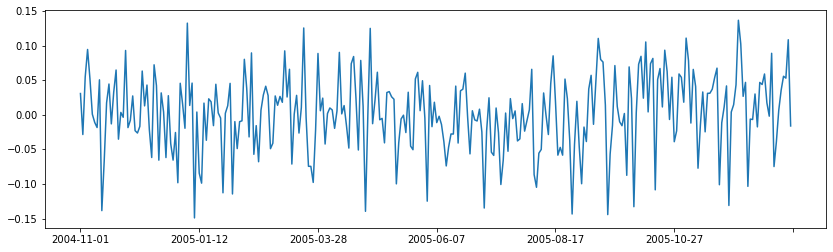

In [277]:
days_df.iloc[:300, 0].plot(figsize=(14, 4));

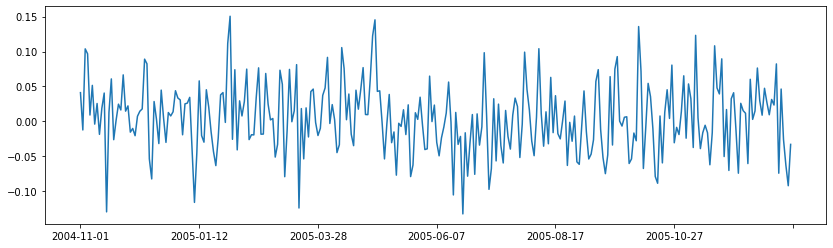

In [278]:
days_df.iloc[:300, 1].plot(figsize=(14, 4));

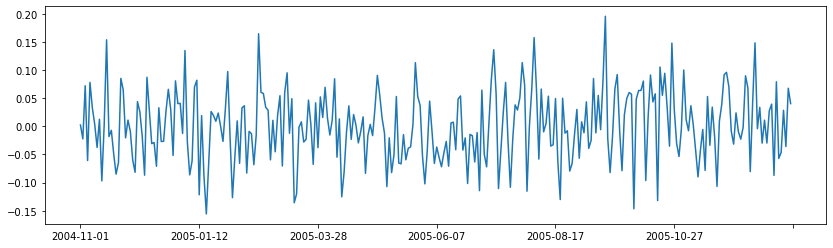

In [279]:
days_df.iloc[:300, 2].plot(figsize=(14, 4));

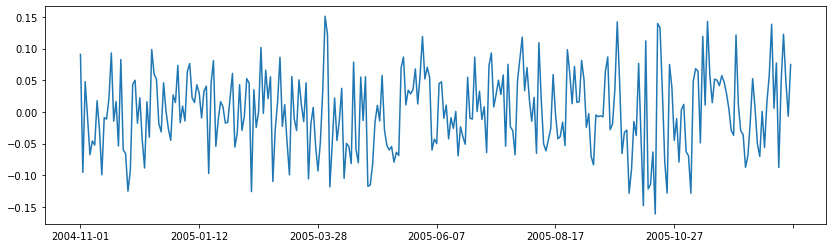

In [280]:
days_df.iloc[:300, 3].plot(figsize=(14, 4));

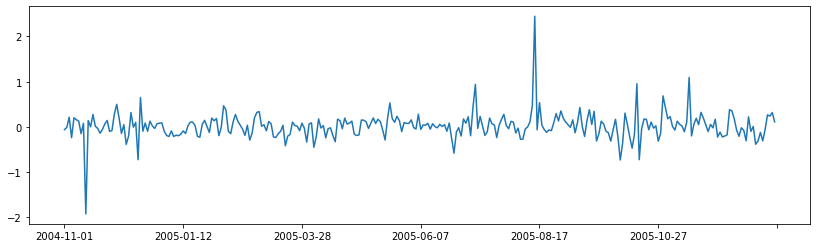

In [281]:
df.loc['2004-11-01':'2018-11-01'].iloc[:300, 0].plot(figsize=(14, 4));

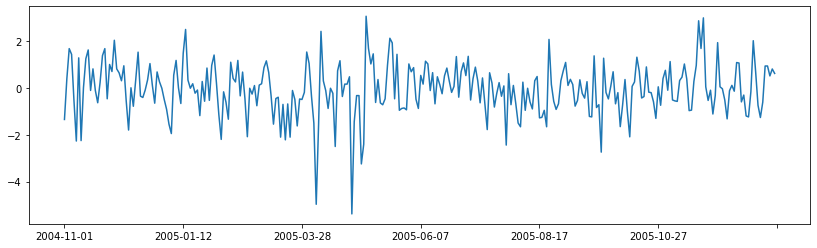

In [282]:
df.loc['2004-11-01':'2018-11-01'].iloc[:300, 2].plot(figsize=(14, 4));

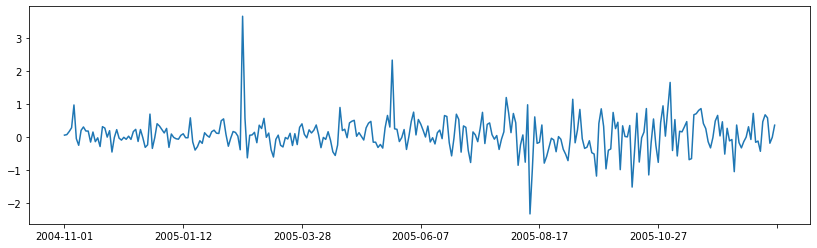

In [283]:
df.loc['2004-11-01':'2018-11-01'].iloc[:300, 4].plot(figsize=(14, 4));

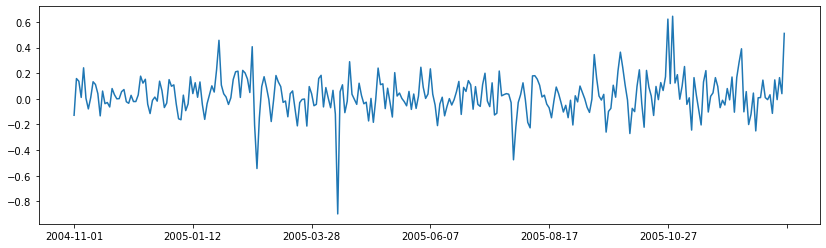

In [284]:
df.loc['2004-11-01':'2018-11-01'].iloc[:300, 6].plot(figsize=(14, 4));

The first graphs seem to have more of a pattern than the last graphs.     
By using SVD I am now trying make predictions for the values in the first graphs instead of the last

In [11]:
#Note: scaled is from the KNN section,the scaled day matrix from the SVD
s_df = pd.DataFrame(scaled, index=days_df.index)

In [13]:
s_df.shape

(3527, 100)

In [208]:
#generate data
lstm_data = {}

for i in range(100):
    
    X = []
    y = []

    for j in range(90, s_df.shape[0]-1):
        X.append(s_df.iloc[j-90:j,i])
        y.append(s_df.iloc[j ,i])
    lstm_data[i] = (X, y)

In [16]:
def split(i):
    
    X = np.array(lstm_data[i][0])
    y = np.array(lstm_data[i][1])
    test_len = 120
    ind_val = np.random.choice(X.shape[0]-test_len, int(X.shape[0]/10), replace=False)
    ind_train = [x for x in range(X.shape[0]-test_len) if x not in ind_val]
    X_train = X[ind_train]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
    y_train = y[ind_train]
    X_val = X[ind_val]
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))
    y_val = y[ind_val]
    X_test = X[-test_len:]
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
    y_test = y[-test_len:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test



In [210]:
X_train, y_train, X_val, y_val, X_test, y_test = split(0)
print(len(X))
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

3436
(2973, 90, 1)
(343, 90, 1)
(120, 90, 1)


### Hyperparameter Tuning

Note: After some hyperparameter tuning on an initial model, I found I got better results with the model I use in my Comparison notebook. With more time I'd like to use this model as a basis for tuning.   

In [62]:
def talos_model(X_train, y_train, X_val, y_val, tal_params):
    
    model = Sequential()
    model.add(LSTM(units=64, stateful=tal_params['stateful'], 
                   use_bias=tal_params['use_bias'], 
                   activation=tal_params['activation'], 
                   return_sequences=True, 
                   input_shape=((X_train.shape[1],1))))
#    model.add(Dropout(0.1))
    model.add(LSTM(units=64, stateful=tal_params['stateful'], 
                   use_bias=tal_params['use_bias'], 
                   activation=tal_params['activation'], 
                   return_sequences=True))
#    model.add(Dropout(0.1))
    model.add(LSTM(units=32, stateful=tal_params['stateful'], 
                   use_bias=tal_params['use_bias'], 
                   activation=tal_params['activation']))
#    model.add(Dropout(0.1))
    model.add(Dense(units=1))
    
    es = EarlyStopping(patience=10, restore_best_weights=True)
    mc = ModelCheckpoint(f'models/{i}.h5', save_best_only=True)
    cb = [mc, es]
    
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X_train, y_train, epochs=50, 
                        batch_size=tal_params['batch_size'], 
                        validation_data=(X_val, y_val), callbacks=cb)    


    return history, model

In [63]:
#tal_params = {'activation': ['relu', 'elu', 'tanh', 'selu']}
tal_params = {'activation': ['relu', 'elu', 'tanh', 'selu'],
              'optimizer': ['adam'],
              'use_bias': [True],
              'stateful': [False],
              'batch_size': [160]
             }

try:
    t1=talos.Scan(x=X_train, y=y_train, x_val=X_val, y_val=y_val, 
                 params=tal_params, model=talos_model, 
                 experiment_name='talos_test')
except:
    print('Error-1--------------------------------')
    
tal_params = {'activation': ['relu'],
              'optimizer': ['adam', 'RMSprop', 'SGD', 'Nadam'],
              'use_bias': [True],
              'stateful': [False],
              'batch_size': [160]
             }

try:
    t2=talos.Scan(x=X_train, y=y_train, x_val=X_val, y_val=y_val, 
                 params=tal_params, model=talos_model, 
                 experiment_name='talos_test')
except:
    print('Error-2--------------------------------')
    
tal_params = {'activation': ['relu'],
              'optimizer': ['adam'],
              'use_bias': [True, False],
              'stateful': [True, False],
              'batch_size': [160]
             }

try:
    t3=talos.Scan(x=X_train, y=y_train, x_val=X_val, y_val=y_val, 
                 params=tal_params, model=talos_model, 
                 experiment_name='talos_test')
except:
    print('Error-3--------------------------------')
    
tal_params = {'activation': ['relu'],
              'optimizer': ['adam'],
              'use_bias': [True],
              'stateful': [False],
              'batch_size': [20, 50, 100, 150, 200, 300, 400, 600]
             }

try:
    t4=talos.Scan(x=X_train, y=y_train, x_val=X_val, y_val=y_val, 
                 params=tal_params, model=talos_model, 
                 experiment_name='talos_test')
except:
    print('Error-4--------------------------------')


    
    


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/50
19/19 [==============================] - 26s 737ms/step - loss: 1.0060 - val_loss: 1.1103
Epoch 2/50
19/19 [==============================] - 12s 581ms/step - loss: 1.0200 - val_loss: 1.1107
Epoch 3/50
19/19 [==============================] - 13s 665ms/step - loss: 1.0050 - val_loss: 1.1111
Epoch 4/50
19/19 [==============================] - 12s 616ms/step - loss: 1.0045 - val_loss: 1.1108
Epoch 5/50
19/19 [==============================] - 8s 419ms/step - loss: 0.9687 - val_loss: 1.1107
Epoch 6/50
19/19 [==============================] - 8s 444ms/step - loss: 0.9830 - val_loss: 1.1105
Epoch 7/50
19/19 [==============================] - 13s 694ms/step - loss: 1.0191 - val_loss: 1.1109
Epoch 8/50
19/19 [==============================] - 11s 547ms/step - loss: 0.9736 - val_loss: 1.1108
Epoch 9/50
19/19 [==============================] - 9s 489ms/step - loss: 1.0205 - val_loss: 1.1110
Epoch 10/50
19/19 [==============================] - 8s 414ms/step - loss: 0.9731 - val_loss: 

 25%|██▌       | 1/4 [02:16<06:48, 136.21s/it]

Epoch 1/50
19/19 [==============================] - 27s 838ms/step - loss: 0.9734 - val_loss: 1.1087
Epoch 2/50
19/19 [==============================] - 9s 462ms/step - loss: 0.9947 - val_loss: 1.1088
Epoch 3/50
19/19 [==============================] - 6s 324ms/step - loss: 0.9678 - val_loss: 1.1089
Epoch 4/50
19/19 [==============================] - 5s 283ms/step - loss: 0.9892 - val_loss: 1.1072
Epoch 5/50
19/19 [==============================] - 6s 344ms/step - loss: 0.9540 - val_loss: 1.1074
Epoch 6/50
19/19 [==============================] - 5s 287ms/step - loss: 0.9900 - val_loss: 1.1073
Epoch 7/50
19/19 [==============================] - 5s 284ms/step - loss: 1.0269 - val_loss: 1.1078
Epoch 8/50
19/19 [==============================] - 5s 284ms/step - loss: 0.9857 - val_loss: 1.1067
Epoch 9/50
19/19 [==============================] - 6s 301ms/step - loss: 1.0094 - val_loss: 1.1063
Epoch 10/50
19/19 [==============================] - 12s 584ms/step - loss: 0.9370 - val_loss: 1.10

 50%|█████     | 2/4 [05:18<05:26, 163.23s/it]

Epoch 1/50
19/19 [==============================] - 33s 895ms/step - loss: 1.0164 - val_loss: 1.1087
Epoch 2/50
19/19 [==============================] - 14s 744ms/step - loss: 1.0257 - val_loss: 1.1085
Epoch 3/50
19/19 [==============================] - 10s 513ms/step - loss: 0.9734 - val_loss: 1.1082
Epoch 4/50
19/19 [==============================] - 8s 443ms/step - loss: 0.9770 - val_loss: 1.1083
Epoch 5/50
19/19 [==============================] - 16s 807ms/step - loss: 1.0368 - val_loss: 1.1079
Epoch 6/50
19/19 [==============================] - 13s 638ms/step - loss: 0.9612 - val_loss: 1.1079
Epoch 7/50
19/19 [==============================] - 8s 415ms/step - loss: 0.9995 - val_loss: 1.1067
Epoch 8/50
19/19 [==============================] - 15s 770ms/step - loss: 0.9571 - val_loss: 1.1078
Epoch 9/50
19/19 [==============================] - 13s 669ms/step - loss: 1.0015 - val_loss: 1.1069
Epoch 10/50
19/19 [==============================] - 12s 630ms/step - loss: 1.0114 - val_loss

 75%|███████▌  | 3/4 [09:02<03:11, 191.17s/it]

Epoch 1/50
19/19 [==============================] - 22s 573ms/step - loss: 1.0932 - val_loss: 1.1600
Epoch 2/50
19/19 [==============================] - 14s 691ms/step - loss: 1.0178 - val_loss: 1.1061
Epoch 3/50
19/19 [==============================] - 14s 721ms/step - loss: 0.9763 - val_loss: 1.1076
Epoch 4/50
19/19 [==============================] - 14s 732ms/step - loss: 0.9805 - val_loss: 1.1097
Epoch 5/50
19/19 [==============================] - 9s 459ms/step - loss: 1.0008 - val_loss: 1.1153
Epoch 6/50
19/19 [==============================] - 8s 414ms/step - loss: 0.9642 - val_loss: 1.1191
Epoch 7/50
19/19 [==============================] - 7s 380ms/step - loss: 0.9787 - val_loss: 1.1187
Epoch 8/50
19/19 [==============================] - 14s 704ms/step - loss: 0.9743 - val_loss: 1.1231
Epoch 9/50
19/19 [==============================] - 12s 582ms/step - loss: 0.9401 - val_loss: 1.1178
Epoch 10/50
19/19 [==============================] - 13s 676ms/step - loss: 0.9275 - val_loss:

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/50
19/19 [==============================] - 23s 677ms/step - loss: 0.9838 - val_loss: 1.1109
Epoch 2/50
19/19 [==============================] - 10s 502ms/step - loss: 0.9649 - val_loss: 1.1110
Epoch 3/50
19/19 [==============================] - 14s 719ms/step - loss: 0.9817 - val_loss: 1.1108
Epoch 4/50
19/19 [==============================] - 14s 734ms/step - loss: 0.9599 - val_loss: 1.1107
Epoch 5/50
19/19 [==============================] - 12s 625ms/step - loss: 1.0199 - val_loss: 1.1107
Epoch 6/50
19/19 [==============================] - 7s 359ms/step - loss: 0.9836 - val_loss: 1.1112
Epoch 7/50
19/19 [==============================] - 14s 691ms/step - loss: 0.9800 - val_loss: 1.1106
Epoch 8/50
19/19 [==============================] - 13s 673ms/step - loss: 0.9602 - val_loss: 1.1107
Epoch 9/50
19/19 [==============================] - 10s 516ms/step - loss: 0.9868 - val_loss: 1.1102
Epoch 10/50
19/19 [==============================] - 9s 477ms/step - loss: 0.9845 - val_loss

 25%|██▌       | 1/4 [07:12<21:37, 432.44s/it]

Epoch 1/50
19/19 [==============================] - 26s 776ms/step - loss: 0.9967 - val_loss: 1.1110
Epoch 2/50
19/19 [==============================] - 14s 732ms/step - loss: 1.0027 - val_loss: 1.1112
Epoch 3/50
19/19 [==============================] - 16s 806ms/step - loss: 1.0155 - val_loss: 1.1106
Epoch 4/50
19/19 [==============================] - 16s 839ms/step - loss: 1.0331 - val_loss: 1.1105
Epoch 5/50
19/19 [==============================] - 10s 540ms/step - loss: 0.9730 - val_loss: 1.1108
Epoch 6/50
19/19 [==============================] - 8s 397ms/step - loss: 0.9858 - val_loss: 1.1104
Epoch 7/50
19/19 [==============================] - 16s 811ms/step - loss: 0.9657 - val_loss: 1.1103
Epoch 8/50
19/19 [==============================] - 14s 729ms/step - loss: 0.9817 - val_loss: 1.1098
Epoch 9/50
19/19 [==============================] - 16s 838ms/step - loss: 1065.4799 - val_loss: 1.1108
Epoch 10/50
19/19 [==============================] - 16s 856ms/step - loss: 0.9717 - val_

 50%|█████     | 2/4 [11:45<11:17, 338.57s/it]

Epoch 1/50
19/19 [==============================] - 24s 727ms/step - loss: 0.9711 - val_loss: 1.1107
Epoch 2/50
19/19 [==============================] - 13s 661ms/step - loss: 1.0040 - val_loss: 1.1107
Epoch 3/50
19/19 [==============================] - 8s 439ms/step - loss: 1.0300 - val_loss: 1.1108
Epoch 4/50
19/19 [==============================] - 7s 347ms/step - loss: 0.9886 - val_loss: 1.1112
Epoch 5/50
19/19 [==============================] - 5s 274ms/step - loss: 0.9714 - val_loss: 1.1109
Epoch 6/50
19/19 [==============================] - 12s 625ms/step - loss: 0.9799 - val_loss: 1.1108
Epoch 7/50
19/19 [==============================] - 12s 582ms/step - loss: 0.9566 - val_loss: 1.1106
Epoch 8/50
19/19 [==============================] - 9s 443ms/step - loss: 1.0340 - val_loss: 1.1106
Epoch 9/50
19/19 [==============================] - 15s 753ms/step - loss: 0.9896 - val_loss: 1.1106
Epoch 10/50
19/19 [==============================] - 12s 611ms/step - loss: 0.9596 - val_loss: 

 75%|███████▌  | 3/4 [19:49<06:45, 405.17s/it]

Epoch 1/50
19/19 [==============================] - 25s 738ms/step - loss: 0.9884 - val_loss: 1.1112
Epoch 2/50
19/19 [==============================] - 13s 637ms/step - loss: 0.9791 - val_loss: 1.1109
Epoch 3/50
19/19 [==============================] - 8s 431ms/step - loss: 0.9606 - val_loss: 1.1111
Epoch 4/50
19/19 [==============================] - 11s 565ms/step - loss: 0.9705 - val_loss: 1.1107
Epoch 5/50
19/19 [==============================] - 11s 591ms/step - loss: 0.9657 - val_loss: 1.1110
Epoch 6/50
19/19 [==============================] - 15s 765ms/step - loss: 0.9914 - val_loss: 1.1109
Epoch 7/50
19/19 [==============================] - 7s 389ms/step - loss: 1.0164 - val_loss: 1.1103
Epoch 8/50
19/19 [==============================] - 13s 655ms/step - loss: 0.9458 - val_loss: 1.1108
Epoch 9/50
19/19 [==============================] - 9s 459ms/step - loss: 1.0145 - val_loss: 1.1108
Epoch 10/50
19/19 [==============================] - 6s 311ms/step - loss: 0.9852 - val_loss: 

  0%|          | 0/8 [00:00<?, ?it/s]

Error-3--------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/50


149/149 [==============================] - 25s 98ms/step - loss: 1.0197 - val_loss: 1.1115
Epoch 2/50
149/149 [==============================] - 11s 75ms/step - loss: 0.9682 - val_loss: 1.1111
Epoch 3/50
149/149 [==============================] - 11s 76ms/step - loss: 0.9944 - val_loss: 1.1112
Epoch 4/50
149/149 [==============================] - 11s 75ms/step - loss: 0.9653 - val_loss: 1.1114
Epoch 5/50
149/149 [==============================] - 12s 79ms/step - loss: 0.9832 - val_loss: 1.1110
Epoch 6/50
149/149 [==============================] - 12s 79ms/step - loss: 0.9832 - val_loss: 1.1111
Epoch 7/50
149/149 [==============================] - 12s 83ms/step - loss: 0.9699 - val_loss: 1.1110
Epoch 8/50
149/149 [==============================] - 27s 178ms/step - loss: 0.9781 - val_loss: 1.1109
Epoch 9/50
149/149 [==============================] - 16s 104ms/step - loss: 0.9593 - val_loss: 1.1109
Epoch 10/50
149/149 [==============================] - 15s 98ms/step - loss: 0.9494 - val_l


 12%|█▎        | 1/8 [16:20<1:54:25, 980.83s/it]

Epoch 1/50
60/60 [==============================] - 21s 163ms/step - loss: 0.9876 - val_loss: 1.1111
Epoch 2/50
60/60 [==============================] - 7s 110ms/step - loss: 0.9718 - val_loss: 1.1110
Epoch 3/50
60/60 [==============================] - 7s 111ms/step - loss: 1.0346 - val_loss: 1.1112
Epoch 4/50
60/60 [==============================] - 6s 97ms/step - loss: 0.9915 - val_loss: 1.1109
Epoch 5/50
60/60 [==============================] - 6s 96ms/step - loss: 0.9762 - val_loss: 1.1116
Epoch 6/50
60/60 [==============================] - 11s 181ms/step - loss: 0.9623 - val_loss: 1.1107
Epoch 7/50
60/60 [==============================] - 11s 175ms/step - loss: 1.0019 - val_loss: 1.1109
Epoch 8/50
60/60 [==============================] - 7s 116ms/step - loss: 0.9693 - val_loss: 1439.9869
Epoch 9/50
60/60 [==============================] - 6s 100ms/step - loss: 118.7930 - val_loss: 1.1114
Epoch 10/50
60/60 [==============================] - 6s 105ms/step - loss: 1.0260 - val_loss: 


 25%|██▌       | 2/8 [20:08<53:48, 538.08s/it]  

Epoch 1/50
30/30 [==============================] - 23s 420ms/step - loss: 0.9599 - val_loss: 1.1108
Epoch 2/50
30/30 [==============================] - 10s 330ms/step - loss: 0.9839 - val_loss: 1.1114
Epoch 3/50
30/30 [==============================] - 7s 233ms/step - loss: 1.0418 - val_loss: 1.1111
Epoch 4/50
30/30 [==============================] - 10s 334ms/step - loss: 0.9740 - val_loss: 1.1110
Epoch 5/50
30/30 [==============================] - 8s 261ms/step - loss: 0.9996 - val_loss: 1.1103
Epoch 6/50
30/30 [==============================] - 13s 430ms/step - loss: 0.9132 - val_loss: 1.1108
Epoch 7/50
30/30 [==============================] - 13s 438ms/step - loss: 1.0006 - val_loss: 1.1110
Epoch 8/50
30/30 [==============================] - 12s 395ms/step - loss: 0.9775 - val_loss: 1.1117
Epoch 9/50
30/30 [==============================] - 8s 269ms/step - loss: 0.9678 - val_loss: 1.1102
Epoch 10/50
30/30 [==============================] - 11s 368ms/step - loss: 0.9990 - val_loss:


 38%|███▊      | 3/8 [28:47<44:06, 529.23s/it]

Epoch 1/50
20/20 [==============================] - 31s 1s/step - loss: 1.0114 - val_loss: 1.1111
Epoch 2/50
20/20 [==============================] - 16s 791ms/step - loss: 1.0031 - val_loss: 1.1116
Epoch 3/50
20/20 [==============================] - 15s 722ms/step - loss: 0.9990 - val_loss: 1.1106
Epoch 4/50
20/20 [==============================] - 9s 428ms/step - loss: 1.0442 - val_loss: 1.1105
Epoch 5/50
20/20 [==============================] - 9s 464ms/step - loss: 1.0173 - val_loss: 1.1117
Epoch 6/50
20/20 [==============================] - 15s 724ms/step - loss: 0.9950 - val_loss: 1.1105
Epoch 7/50
20/20 [==============================] - 17s 845ms/step - loss: 0.9633 - val_loss: 1.1113
Epoch 8/50
20/20 [==============================] - 14s 682ms/step - loss: 1812661.2765 - val_loss: 1.1107
Epoch 9/50
20/20 [==============================] - 19s 919ms/step - loss: 0.9929 - val_loss: 1.1107
Epoch 10/50
20/20 [==============================] - 16s 755ms/step - loss: 0.9906 - val_l


 50%|█████     | 4/8 [32:24<27:03, 405.84s/it]

Epoch 1/50
15/15 [==============================] - 23s 788ms/step - loss: 0.9709 - val_loss: 1.1119
Epoch 2/50
15/15 [==============================] - 13s 802ms/step - loss: 1.0017 - val_loss: 1.1112
Epoch 3/50
15/15 [==============================] - 11s 709ms/step - loss: 1.0204 - val_loss: 1.1113
Epoch 4/50
15/15 [==============================] - 12s 755ms/step - loss: 1.0157 - val_loss: 1.1109
Epoch 5/50
15/15 [==============================] - 12s 737ms/step - loss: 0.9562 - val_loss: 1.1110
Epoch 6/50
15/15 [==============================] - 12s 775ms/step - loss: 0.9740 - val_loss: 1.1108
Epoch 7/50
15/15 [==============================] - 9s 625ms/step - loss: 1.0214 - val_loss: 1.1106
Epoch 8/50
15/15 [==============================] - 10s 606ms/step - loss: 0.9751 - val_loss: 1.1111
Epoch 9/50
15/15 [==============================] - 7s 473ms/step - loss: 0.9858 - val_loss: 1.1105
Epoch 10/50
15/15 [==============================] - 11s 717ms/step - loss: 0.9723 - val_loss


 62%|██████▎   | 5/8 [37:42<18:42, 374.30s/it]

Epoch 1/50
10/10 [==============================] - 24s 1s/step - loss: 1.0328 - val_loss: 1.1110
Epoch 2/50
10/10 [==============================] - 16s 2s/step - loss: 0.9617 - val_loss: 1.1112
Epoch 3/50
10/10 [==============================] - 14s 1s/step - loss: 0.9915 - val_loss: 1.1104
Epoch 4/50
10/10 [==============================] - 6s 640ms/step - loss: 1.0213 - val_loss: 1.1110
Epoch 5/50
10/10 [==============================] - 11s 1s/step - loss: 1.0004 - val_loss: 1.1107
Epoch 6/50
10/10 [==============================] - 14s 1s/step - loss: 0.9748 - val_loss: 1.1106
Epoch 7/50
10/10 [==============================] - 15s 1s/step - loss: 0.9819 - val_loss: 1.1104
Epoch 8/50
10/10 [==============================] - 12s 1s/step - loss: 1.0111 - val_loss: 1.1102
Epoch 9/50
10/10 [==============================] - 14s 1s/step - loss: 1.0008 - val_loss: 1.1101
Epoch 10/50
10/10 [==============================] - 12s 1s/step - loss: 0.9886 - val_loss: 1.1097
Epoch 11/50
10/10


 75%|███████▌  | 6/8 [42:31<11:30, 345.20s/it]

Epoch 1/50
8/8 [==============================] - 24s 2s/step - loss: 1.0047 - val_loss: 1.1111
Epoch 2/50
8/8 [==============================] - 14s 2s/step - loss: 0.9923 - val_loss: 1.1124
Epoch 3/50
8/8 [==============================] - 12s 1s/step - loss: 0.9967 - val_loss: 1.1108
Epoch 4/50
8/8 [==============================] - 11s 1s/step - loss: 0.9836 - val_loss: 1.1107
Epoch 5/50
8/8 [==============================] - 9s 1s/step - loss: 0.9943 - val_loss: 1.1109
Epoch 6/50
8/8 [==============================] - 15s 2s/step - loss: 0.9887 - val_loss: 1.1108
Epoch 7/50
8/8 [==============================] - 12s 1s/step - loss: 1.0065 - val_loss: 1.1105
Epoch 8/50
8/8 [==============================] - 8s 996ms/step - loss: 1.0290 - val_loss: 1.1106
Epoch 9/50
8/8 [==============================] - 7s 922ms/step - loss: 0.9947 - val_loss: 1.1106
Epoch 10/50
8/8 [==============================] - 7s 837ms/step - loss: 0.9995 - val_loss: 1.1115
Epoch 11/50
8/8 [=================


 88%|████████▊ | 7/8 [47:48<05:36, 336.10s/it]

Epoch 1/50
5/5 [==============================] - 24s 3s/step - loss: 0.9658 - val_loss: 1.1114
Epoch 2/50
5/5 [==============================] - 13s 2s/step - loss: 0.9720 - val_loss: 1.1111
Epoch 3/50
5/5 [==============================] - 6s 1s/step - loss: 0.9860 - val_loss: 1.1110
Epoch 4/50
5/5 [==============================] - 11s 2s/step - loss: 0.9876 - val_loss: 1.1107
Epoch 5/50
5/5 [==============================] - 14s 3s/step - loss: 0.9932 - val_loss: 1.1106
Epoch 6/50
5/5 [==============================] - 15s 3s/step - loss: 0.9697 - val_loss: 1.1105
Epoch 7/50
5/5 [==============================] - 14s 3s/step - loss: 0.9853 - val_loss: 1.1101
Epoch 8/50
5/5 [==============================] - 13s 3s/step - loss: 0.9805 - val_loss: 1.1108
Epoch 9/50
5/5 [==============================] - 13s 2s/step - loss: 1.0061 - val_loss: 1.1119
Epoch 10/50
5/5 [==============================] - 14s 3s/step - loss: 0.9838 - val_loss: 1.1123
Epoch 11/50
5/5 [=======================


100%|██████████| 8/8 [51:59<00:00, 390.00s/it]


In [70]:
# tal_params = {'activation': ['relu'],
#               'optimizer': ['adam'],
#               'use_bias': [True, False],
#               'stateful': [True],
#               'batch_size': [160]
#              }

# try:
#     t3a=talos.Scan(x=X_train, y=y_train, x_val=X_val, y_val=y_val, 
#                  params=tal_params, model=talos_model, 
#                  experiment_name='talos_test')
# except:
#     print('Error-3a--------------------------------')
    
tal_params = {'activation': ['relu'],
              'optimizer': ['adam'],
              'use_bias': [True],
              'stateful': [False],
              'batch_size': [160]
             }

try:
    t3b=talos.Scan(x=X_train, y=y_train, x_val=X_val, y_val=y_val, 
                 params=tal_params, model=talos_model, 
                 experiment_name='talos_test')
except:
    print('Error-3b--------------------------------')
tal_params = {'activation': ['relu'],
              'optimizer': ['adam'],
              'use_bias': [False],
              'stateful': [False],
              'batch_size': [160]
             }

try:
    t3b=talos.Scan(x=X_train, y=y_train, x_val=X_val, y_val=y_val, 
                 params=tal_params, model=talos_model, 
                 experiment_name='talos_test')
except:
    print('Error-3c--------------------------------')
    
    
tal_params = {'activation': ['relu'],
              'optimizer': ['adam'],
              'use_bias': [False],
              'stateful': [True],
              'batch_size': [160]
             }

try:
    t3b=talos.Scan(x=X_train, y=y_train, x_val=X_val, y_val=y_val, 
                 params=tal_params, model=talos_model, 
                 experiment_name='talos_test')
except:
    print('Error-3d--------------------------------')
    
    
tal_params = {'activation': ['relu'],
              'optimizer': ['adam'],
              'use_bias': [True],
              'stateful': [True],
              'batch_size': [160]
             }

try:
    t3b=talos.Scan(x=X_train, y=y_train, x_val=X_val, y_val=y_val, 
                 params=tal_params, model=talos_model, 
                 experiment_name='talos_test')
except:
    print('Error-3e--------------------------------')

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/50
19/19 [==============================] - 23s 525ms/step - loss: 0.9756 - val_loss: 1.1110
Epoch 2/50
19/19 [==============================] - 5s 282ms/step - loss: 0.9774 - val_loss: 1.1111
Epoch 3/50
19/19 [==============================] - 5s 284ms/step - loss: 0.9762 - val_loss: 1.1106
Epoch 4/50
19/19 [==============================] - 5s 279ms/step - loss: 1.0052 - val_loss: 1.1110
Epoch 5/50
19/19 [==============================] - 5s 286ms/step - loss: 0.9753 - val_loss: 1.1108
Epoch 6/50
19/19 [==============================] - 5s 279ms/step - loss: 0.9901 - val_loss: 1.1135
Epoch 7/50
19/19 [==============================] - 6s 302ms/step - loss: 0.9586 - val_loss: 1.1105
Epoch 8/50
19/19 [==============================] - 11s 566ms/step - loss: 0.9892 - val_loss: 1.1106
Epoch 9/50
19/19 [==============================] - 8s 397ms/step - loss: 0.9761 - val_loss: 1.1103
Epoch 10/50
19/19 [==============================] - 12s 621ms/step - loss: 1.0068 - val_loss: 1.1

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/50
19/19 [==============================] - 18s 472ms/step - loss: 0.9510 - val_loss: 1.1111
Epoch 2/50
19/19 [==============================] - 5s 258ms/step - loss: 0.9772 - val_loss: 1.1110
Epoch 3/50
19/19 [==============================] - 5s 247ms/step - loss: 0.9872 - val_loss: 1.1110
Epoch 4/50
19/19 [==============================] - 5s 254ms/step - loss: 1.0092 - val_loss: 1.1109
Epoch 5/50
19/19 [==============================] - 5s 249ms/step - loss: 0.9392 - val_loss: 1.1108
Epoch 6/50
19/19 [==============================] - 5s 262ms/step - loss: 1.0028 - val_loss: 1.1107
Epoch 7/50
19/19 [==============================] - 5s 268ms/step - loss: 0.9679 - val_loss: 1.1106
Epoch 8/50
19/19 [==============================] - 5s 271ms/step - loss: 0.9859 - val_loss: 1.1105
Epoch 9/50
19/19 [==============================] - 5s 254ms/step - loss: 0.9982 - val_loss: 1.1097
Epoch 10/50
19/19 [==============================] - 5s 262ms/step - loss: 0.9587 - val_loss: 1.109

  0%|          | 0/1 [00:00<?, ?it/s]

Error-3d--------------------------------
Error-3e--------------------------------


### Modelling

In [73]:
for i in range(100):
    print(i, '-------------------------------------------------')
    
    X_train, y_train, X_val, y_val, X_test, y_test = split(i)
    
    model = Sequential()
    model.add(LSTM(units=64, activation='elu', return_sequences=True, input_shape=((X_train.shape[1],1))))
#    model.add(Dropout(0.1))
    model.add(LSTM(units=64, activation='elu', return_sequences=True))
#    model.add(Dropout(0.1))
    model.add(LSTM(units=32, activation='elu'))
#    model.add(Dropout(0.1))
    model.add(Dense(units=1))
    
    es = EarlyStopping(patience=10, restore_best_weights=True)
    mc = ModelCheckpoint(f'models/{i}b.h5', save_best_only=True)
    cb = [mc, es]
    
    nadam = Nadam(lr=0.0003)
    
    model.compile(optimizer=nadam, loss='mse')
    history = model.fit(X_train, y_train, epochs=200, batch_size=100, validation_data=(X_val, y_val), callbacks=cb)
    print(min(history.history['val_loss']))
    

0 -------------------------------------------------
Epoch 1/200
30/30 [==============================] - 24s 360ms/step - loss: 0.9490 - val_loss: 1.0563
Epoch 2/200
30/30 [==============================] - 8s 271ms/step - loss: 1.0069 - val_loss: 1.0592
Epoch 3/200
30/30 [==============================] - 7s 221ms/step - loss: 0.9678 - val_loss: 1.0613
Epoch 4/200
30/30 [==============================] - 10s 319ms/step - loss: 0.9976 - val_loss: 1.0628
Epoch 5/200
30/30 [==============================] - 6s 216ms/step - loss: 1.0178 - val_loss: 1.0628
Epoch 6/200
30/30 [==============================] - 7s 228ms/step - loss: 0.9829 - val_loss: 1.0643
Epoch 7/200
30/30 [==============================] - 5s 181ms/step - loss: 1.0030 - val_loss: 1.0640
Epoch 8/200
30/30 [==============================] - 6s 184ms/step - loss: 0.9963 - val_loss: 1.0650
Epoch 9/200
30/30 [==============================] - 9s 307ms/step - loss: 0.9994 - val_loss: 1.0669
Epoch 10/200
30/30 [=================

30/30 [==============================] - 12s 380ms/step - loss: 1.0212 - val_loss: 1.0522
Epoch 21/200
30/30 [==============================] - 5s 172ms/step - loss: 0.9604 - val_loss: 1.0504
Epoch 22/200
30/30 [==============================] - 5s 167ms/step - loss: 0.9687 - val_loss: 1.0513
Epoch 23/200
30/30 [==============================] - 8s 270ms/step - loss: 1.0225 - val_loss: 1.0500
Epoch 24/200
30/30 [==============================] - 6s 191ms/step - loss: 0.9883 - val_loss: 1.0517
Epoch 25/200
30/30 [==============================] - 5s 178ms/step - loss: 0.9693 - val_loss: 1.0474
Epoch 26/200
30/30 [==============================] - 5s 158ms/step - loss: 1.0095 - val_loss: 1.0470
Epoch 27/200
30/30 [==============================] - 10s 339ms/step - loss: 0.9781 - val_loss: 1.0481
Epoch 28/200
30/30 [==============================] - 7s 225ms/step - loss: 1.0254 - val_loss: 1.0534
Epoch 29/200
30/30 [==============================] - 9s 301ms/step - loss: 0.9632 - val_loss

30/30 [==============================] - 7s 242ms/step - loss: 1.0210 - val_loss: 1.0936
Epoch 9/200
30/30 [==============================] - 8s 246ms/step - loss: 1.0211 - val_loss: 1.0953
Epoch 10/200
30/30 [==============================] - 5s 179ms/step - loss: 0.9988 - val_loss: 1.0972
Epoch 11/200
30/30 [==============================] - 5s 166ms/step - loss: 1.0470 - val_loss: 1.0955
Epoch 12/200
30/30 [==============================] - 4s 143ms/step - loss: 0.9916 - val_loss: 1.0824
Epoch 13/200
30/30 [==============================] - 10s 328ms/step - loss: 1.0043 - val_loss: 1.0934
Epoch 14/200
30/30 [==============================] - 5s 167ms/step - loss: 0.9738 - val_loss: 1.0926
Epoch 15/200
30/30 [==============================] - 5s 160ms/step - loss: 0.9594 - val_loss: 1.0953
Epoch 16/200
30/30 [==============================] - 10s 306ms/step - loss: 0.9956 - val_loss: 1.0915
Epoch 17/200
30/30 [==============================] - 5s 171ms/step - loss: 1.0168 - val_loss:

Epoch 29/200
30/30 [==============================] - 4s 148ms/step - loss: nan - val_loss: nan
Epoch 30/200
30/30 [==============================] - 4s 149ms/step - loss: nan - val_loss: nan
Epoch 31/200
30/30 [==============================] - 5s 164ms/step - loss: nan - val_loss: nan
Epoch 32/200
30/30 [==============================] - 11s 370ms/step - loss: nan - val_loss: nan
Epoch 33/200
30/30 [==============================] - 6s 190ms/step - loss: nan - val_loss: nan
Epoch 34/200
30/30 [==============================] - 7s 244ms/step - loss: nan - val_loss: nan
0.9894843101501465
16 -------------------------------------------------
Epoch 1/200
30/30 [==============================] - 22s 324ms/step - loss: 1.0104 - val_loss: 1.1444
Epoch 2/200
30/30 [==============================] - 10s 316ms/step - loss: 1.0070 - val_loss: 1.1442
Epoch 3/200
30/30 [==============================] - 9s 279ms/step - loss: 1.0007 - val_loss: 1.1442
Epoch 4/200
30/30 [===========================

Epoch 17/200
30/30 [==============================] - 6s 209ms/step - loss: 0.9932 - val_loss: 0.9436
Epoch 18/200
30/30 [==============================] - 6s 205ms/step - loss: 0.9905 - val_loss: 0.9467
Epoch 19/200
30/30 [==============================] - 6s 211ms/step - loss: 1.0180 - val_loss: 0.9465
Epoch 20/200
30/30 [==============================] - 7s 224ms/step - loss: 1.0028 - val_loss: 0.9426
Epoch 21/200
30/30 [==============================] - 16s 523ms/step - loss: 0.9651 - val_loss: 0.9429
Epoch 22/200
30/30 [==============================] - 10s 341ms/step - loss: 1.0094 - val_loss: 0.9451
Epoch 23/200
30/30 [==============================] - 8s 259ms/step - loss: 0.9831 - val_loss: 0.9446
Epoch 24/200
30/30 [==============================] - 7s 226ms/step - loss: 0.9766 - val_loss: 0.9433
Epoch 25/200
30/30 [==============================] - 7s 218ms/step - loss: 1.0030 - val_loss: 0.9399
Epoch 26/200
30/30 [==============================] - 10s 325ms/step - loss: 0.9

30/30 [==============================] - 20s 645ms/step - loss: 1.0211 - val_loss: 1.0297
Epoch 4/200
30/30 [==============================] - 18s 584ms/step - loss: 0.9532 - val_loss: 1.0366
Epoch 5/200
30/30 [==============================] - 19s 620ms/step - loss: 0.9400 - val_loss: 1.0322
Epoch 6/200
30/30 [==============================] - 16s 511ms/step - loss: 0.9627 - val_loss: 1.0327
Epoch 7/200
30/30 [==============================] - 19s 618ms/step - loss: 1.0049 - val_loss: 1.0353
Epoch 8/200
30/30 [==============================] - 15s 505ms/step - loss: 0.9749 - val_loss: 1.0335
Epoch 9/200
30/30 [==============================] - 19s 616ms/step - loss: 0.9789 - val_loss: 1.0318
Epoch 10/200
30/30 [==============================] - 19s 624ms/step - loss: 0.9802 - val_loss: 1.0333
Epoch 11/200
30/30 [==============================] - 23s 756ms/step - loss: 0.9672 - val_loss: 1.0327
Epoch 12/200
30/30 [==============================] - 20s 653ms/step - loss: 0.9857 - val_lo

30/30 [==============================] - 33s 1s/step - loss: 0.9765 - val_loss: 0.8969
Epoch 17/200
30/30 [==============================] - 31s 1s/step - loss: 0.9975 - val_loss: 0.8968
Epoch 18/200
30/30 [==============================] - 11s 366ms/step - loss: 0.9949 - val_loss: 0.8918
Epoch 19/200
30/30 [==============================] - 12s 396ms/step - loss: 0.9835 - val_loss: 0.9016
Epoch 20/200
30/30 [==============================] - 31s 1s/step - loss: 1.0376 - val_loss: 0.9015
Epoch 21/200
30/30 [==============================] - 28s 932ms/step - loss: 0.9595 - val_loss: 0.8981
Epoch 22/200
30/30 [==============================] - 27s 901ms/step - loss: 0.9987 - val_loss: 0.9010
Epoch 23/200
30/30 [==============================] - 26s 843ms/step - loss: 0.9712 - val_loss: 0.9020
Epoch 24/200
30/30 [==============================] - 32s 1s/step - loss: 0.9650 - val_loss: 0.9062
Epoch 25/200
30/30 [==============================] - 34s 1s/step - loss: 0.9607 - val_loss: 0.905

Epoch 11/200
30/30 [==============================] - 36s 1s/step - loss: 1.0189 - val_loss: 1.0042
Epoch 12/200
30/30 [==============================] - 35s 1s/step - loss: 0.9876 - val_loss: 1.0045
Epoch 13/200
30/30 [==============================] - 35s 1s/step - loss: 1.0057 - val_loss: 1.0051
1.0034877061843872
39 -------------------------------------------------
Epoch 1/200
30/30 [==============================] - 53s 1s/step - loss: 0.9443 - val_loss: 1.0861
Epoch 2/200
30/30 [==============================] - 37s 1s/step - loss: 0.9039 - val_loss: 1.0861
Epoch 3/200
30/30 [==============================] - 40s 1s/step - loss: 0.9345 - val_loss: 1.0864
Epoch 4/200
30/30 [==============================] - 39s 1s/step - loss: 0.9404 - val_loss: 1.0861
Epoch 5/200
30/30 [==============================] - 35s 1s/step - loss: 0.9959 - val_loss: 1.0859
Epoch 6/200
30/30 [==============================] - 35s 1s/step - loss: 0.9573 - val_loss: 1.0859
Epoch 7/200
30/30 [===============

30/30 [==============================] - 45s 2s/step - loss: 0.9312 - val_loss: 1.0897
Epoch 15/200
30/30 [==============================] - 45s 1s/step - loss: 0.9194 - val_loss: 1.0912
Epoch 16/200
30/30 [==============================] - 42s 1s/step - loss: 0.9440 - val_loss: 1.0908
Epoch 17/200
30/30 [==============================] - 44s 1s/step - loss: 0.9765 - val_loss: 1.0913
1.089197039604187
47 -------------------------------------------------
Epoch 1/200
30/30 [==============================] - 75s 762ms/step - loss: 0.9762 - val_loss: 0.8968
Epoch 2/200
30/30 [==============================] - 26s 861ms/step - loss: 0.9956 - val_loss: 0.8959
Epoch 3/200
30/30 [==============================] - 25s 832ms/step - loss: 0.9723 - val_loss: 0.8973
Epoch 4/200
30/30 [==============================] - 15s 490ms/step - loss: 0.9989 - val_loss: 0.8972
Epoch 5/200
30/30 [==============================] - 14s 483ms/step - loss: 0.9719 - val_loss: 0.8971
Epoch 6/200
30/30 [=============

30/30 [==============================] - 34s 1s/step - loss: 1.0289 - val_loss: 1.0508
Epoch 25/200
30/30 [==============================] - 36s 1s/step - loss: 0.9887 - val_loss: 1.0499
Epoch 26/200
30/30 [==============================] - 38s 1s/step - loss: 0.9989 - val_loss: 1.0529
Epoch 27/200
30/30 [==============================] - 40s 1s/step - loss: 1.0002 - val_loss: 1.0550
Epoch 28/200
30/30 [==============================] - 38s 1s/step - loss: 0.9552 - val_loss: 1.0513
Epoch 29/200
30/30 [==============================] - 38s 1s/step - loss: 1.0033 - val_loss: 1.0500
Epoch 30/200
30/30 [==============================] - 38s 1s/step - loss: 0.9618 - val_loss: 1.0557
Epoch 31/200
30/30 [==============================] - 38s 1s/step - loss: 0.9860 - val_loss: 1.0551
Epoch 32/200
30/30 [==============================] - 37s 1s/step - loss: 1.0184 - val_loss: 1.0586
Epoch 33/200
30/30 [==============================] - 40s 1s/step - loss: 1.0097 - val_loss: 1.0523
Epoch 34/200


30/30 [==============================] - 51s 2s/step - loss: 1.0209 - val_loss: 0.8716
Epoch 5/200
30/30 [==============================] - 53s 2s/step - loss: 1.0014 - val_loss: 0.8703
Epoch 6/200
30/30 [==============================] - 54s 2s/step - loss: 1.0319 - val_loss: 0.8687
Epoch 7/200
30/30 [==============================] - 55s 2s/step - loss: 1.0477 - val_loss: 0.8688
Epoch 8/200
30/30 [==============================] - 53s 2s/step - loss: 1.0241 - val_loss: 0.8627
Epoch 9/200
30/30 [==============================] - 50s 2s/step - loss: 1.0018 - val_loss: 0.8602
Epoch 10/200
30/30 [==============================] - 54s 2s/step - loss: 0.9929 - val_loss: 0.8570
Epoch 11/200
30/30 [==============================] - 53s 2s/step - loss: 1.0092 - val_loss: 0.8599
Epoch 12/200
30/30 [==============================] - 49s 2s/step - loss: 1.0002 - val_loss: 0.8569
Epoch 13/200
30/30 [==============================] - 52s 2s/step - loss: 0.9822 - val_loss: 0.8604
Epoch 14/200
30/30

Epoch 5/200
30/30 [==============================] - 54s 2s/step - loss: 0.9957 - val_loss: 0.9783
Epoch 6/200
30/30 [==============================] - 56s 2s/step - loss: 1.0472 - val_loss: 0.9813
Epoch 7/200
30/30 [==============================] - 54s 2s/step - loss: 0.9640 - val_loss: 0.9844
Epoch 8/200
30/30 [==============================] - 51s 2s/step - loss: 0.9998 - val_loss: 0.9869
Epoch 9/200
30/30 [==============================] - 53s 2s/step - loss: 0.9841 - val_loss: 0.9860
Epoch 10/200
30/30 [==============================] - 53s 2s/step - loss: 0.9900 - val_loss: 0.9891
Epoch 11/200
30/30 [==============================] - 55s 2s/step - loss: 0.9793 - val_loss: 0.9854
0.9704920053482056
63 -------------------------------------------------
Epoch 1/200
30/30 [==============================] - 62s 2s/step - loss: 0.9963 - val_loss: 0.9721
Epoch 2/200
30/30 [==============================] - 31s 1s/step - loss: 0.9610 - val_loss: 0.9723
Epoch 3/200
30/30 [================

30/30 [==============================] - 53s 2s/step - loss: 0.9866 - val_loss: 0.9611
Epoch 39/200
30/30 [==============================] - 59s 2s/step - loss: 0.9901 - val_loss: 0.9582
0.9482982158660889
69 -------------------------------------------------
Epoch 1/200
30/30 [==============================] - 70s 2s/step - loss: 0.9913 - val_loss: 1.1284
Epoch 2/200
30/30 [==============================] - 54s 2s/step - loss: 0.9652 - val_loss: 1.1286
Epoch 3/200
30/30 [==============================] - 51s 2s/step - loss: 0.9760 - val_loss: 1.1286
Epoch 4/200
30/30 [==============================] - 56s 2s/step - loss: 0.9858 - val_loss: 1.1287
Epoch 5/200
30/30 [==============================] - 59s 2s/step - loss: 1.0014 - val_loss: 1.1291
Epoch 6/200
30/30 [==============================] - 53s 2s/step - loss: 0.9494 - val_loss: 1.1291
Epoch 7/200
30/30 [==============================] - 58s 2s/step - loss: 0.9650 - val_loss: 1.1289
Epoch 8/200
30/30 [=============================

30/30 [==============================] - 54s 2s/step - loss: 0.9826 - val_loss: 1.0585
Epoch 56/200
30/30 [==============================] - 56s 2s/step - loss: 0.9575 - val_loss: 1.0570
Epoch 57/200
30/30 [==============================] - 55s 2s/step - loss: 1.0144 - val_loss: 1.0564
Epoch 58/200
30/30 [==============================] - 54s 2s/step - loss: 1.0095 - val_loss: 1.0554
Epoch 59/200
30/30 [==============================] - 56s 2s/step - loss: 0.9983 - val_loss: 1.0563
Epoch 60/200
30/30 [==============================] - 51s 2s/step - loss: 0.9715 - val_loss: 1.0551
Epoch 61/200
30/30 [==============================] - 55s 2s/step - loss: 1.0074 - val_loss: 1.0559
Epoch 62/200
30/30 [==============================] - 18s 588ms/step - loss: 1.0209 - val_loss: 1.0539
Epoch 63/200
30/30 [==============================] - 30s 1s/step - loss: 1.0255 - val_loss: 1.0541
Epoch 64/200
30/30 [==============================] - 48s 2s/step - loss: 0.9987 - val_loss: 1.0535
Epoch 65/2

30/30 [==============================] - 55s 2s/step - loss: 1.0329 - val_loss: 0.8821
Epoch 7/200
30/30 [==============================] - 54s 2s/step - loss: 1.0135 - val_loss: 0.8830
Epoch 8/200
30/30 [==============================] - 56s 2s/step - loss: 1.0294 - val_loss: 0.8819
Epoch 9/200
30/30 [==============================] - 58s 2s/step - loss: 1.0112 - val_loss: 0.8808
Epoch 10/200
30/30 [==============================] - 58s 2s/step - loss: 0.9890 - val_loss: 0.8822
Epoch 11/200
30/30 [==============================] - 51s 2s/step - loss: 1.0155 - val_loss: 0.8826
Epoch 12/200
30/30 [==============================] - 39s 1s/step - loss: 1.0125 - val_loss: 0.8829
Epoch 13/200
30/30 [==============================] - 52s 2s/step - loss: 1.0125 - val_loss: 0.8845
Epoch 14/200
30/30 [==============================] - 58s 2s/step - loss: 1.0289 - val_loss: 0.8826
0.880351722240448
78 -------------------------------------------------
Epoch 1/200
30/30 [==========================

30/30 [==============================] - 53s 2s/step - loss: 1.0122 - val_loss: 0.9517
Epoch 18/200
30/30 [==============================] - 51s 2s/step - loss: 1.0388 - val_loss: 0.9535
Epoch 19/200
30/30 [==============================] - 53s 2s/step - loss: 0.9310 - val_loss: 0.9532
Epoch 20/200
30/30 [==============================] - 54s 2s/step - loss: 0.9468 - val_loss: 0.9534
Epoch 21/200
30/30 [==============================] - 53s 2s/step - loss: 0.9665 - val_loss: 0.9571
Epoch 22/200
30/30 [==============================] - 50s 2s/step - loss: 0.9615 - val_loss: 0.9511
Epoch 23/200
30/30 [==============================] - 51s 2s/step - loss: 1.0057 - val_loss: 0.9499
Epoch 24/200
30/30 [==============================] - 53s 2s/step - loss: 0.9370 - val_loss: 0.9540
Epoch 25/200
30/30 [==============================] - 46s 2s/step - loss: 0.9980 - val_loss: 0.9537
Epoch 26/200
30/30 [==============================] - 50s 2s/step - loss: 0.9625 - val_loss: 0.9587
Epoch 27/200


30/30 [==============================] - 52s 2s/step - loss: 0.9387 - val_loss: 0.9860
Epoch 104/200
30/30 [==============================] - 53s 2s/step - loss: 0.9552 - val_loss: 0.9860
Epoch 105/200
30/30 [==============================] - 50s 2s/step - loss: 0.9653 - val_loss: 0.9859
Epoch 106/200
30/30 [==============================] - 50s 2s/step - loss: 0.8917 - val_loss: 0.9855
Epoch 107/200
30/30 [==============================] - 52s 2s/step - loss: 0.9279 - val_loss: 0.9857
Epoch 108/200
30/30 [==============================] - 46s 2s/step - loss: 0.9803 - val_loss: 0.9861
Epoch 109/200
30/30 [==============================] - 46s 2s/step - loss: 0.9927 - val_loss: 0.9858
Epoch 110/200
30/30 [==============================] - 53s 2s/step - loss: 0.9798 - val_loss: 0.9857
Epoch 111/200
30/30 [==============================] - 52s 2s/step - loss: 0.9681 - val_loss: 0.9857
Epoch 112/200
30/30 [==============================] - 52s 2s/step - loss: 0.9514 - val_loss: 0.9858
Epoc

30/30 [==============================] - 48s 2s/step - loss: 1.0030 - val_loss: 1.0273
Epoch 14/200
30/30 [==============================] - 37s 1s/step - loss: 1.0287 - val_loss: 1.0276
Epoch 15/200
30/30 [==============================] - 45s 2s/step - loss: 0.9996 - val_loss: 1.0289
Epoch 16/200
30/30 [==============================] - 49s 2s/step - loss: 0.9549 - val_loss: 1.0290
Epoch 17/200
30/30 [==============================] - 50s 2s/step - loss: 0.9789 - val_loss: 1.0288
Epoch 18/200
30/30 [==============================] - 48s 2s/step - loss: 0.9789 - val_loss: 1.0293
Epoch 19/200
30/30 [==============================] - 51s 2s/step - loss: 0.9877 - val_loss: 1.0269
Epoch 20/200
30/30 [==============================] - 49s 2s/step - loss: 0.9701 - val_loss: 1.0274
Epoch 21/200
30/30 [==============================] - 49s 2s/step - loss: 1.0365 - val_loss: 1.0299
Epoch 22/200
30/30 [==============================] - 46s 2s/step - loss: 5.2867 - val_loss: 1.0352
Epoch 23/200


30/30 [==============================] - 48s 2s/step - loss: 0.9726 - val_loss: 1.0382
Epoch 3/200
30/30 [==============================] - 52s 2s/step - loss: 0.9462 - val_loss: 1.0380
Epoch 4/200
30/30 [==============================] - 49s 2s/step - loss: 0.9462 - val_loss: 1.0375
Epoch 5/200
30/30 [==============================] - 48s 2s/step - loss: 0.9664 - val_loss: 1.0370
Epoch 6/200
30/30 [==============================] - 48s 2s/step - loss: 0.9765 - val_loss: 1.0378
Epoch 7/200
30/30 [==============================] - 48s 2s/step - loss: 1.0160 - val_loss: 1.0374
Epoch 8/200
30/30 [==============================] - 51s 2s/step - loss: 0.9571 - val_loss: 1.0370
Epoch 9/200
30/30 [==============================] - 48s 2s/step - loss: 0.9574 - val_loss: 1.0370
Epoch 10/200
30/30 [==============================] - 49s 2s/step - loss: 0.9963 - val_loss: 1.0374
Epoch 11/200
30/30 [==============================] - 49s 2s/step - loss: 0.9449 - val_loss: 1.0377
Epoch 12/200
30/30 [

Epoch 54/200
30/30 [==============================] - 45s 1s/step - loss: 0.9311 - val_loss: 1.0281
Epoch 55/200
30/30 [==============================] - 48s 2s/step - loss: 0.9612 - val_loss: 1.0288
1.0235764980316162
96 -------------------------------------------------
Epoch 1/200
30/30 [==============================] - 42s 1s/step - loss: 0.9599 - val_loss: 1.0681
Epoch 2/200
30/30 [==============================] - 27s 891ms/step - loss: 0.9700 - val_loss: 1.0694
Epoch 3/200
30/30 [==============================] - 16s 520ms/step - loss: 0.9864 - val_loss: 1.0708
Epoch 4/200
30/30 [==============================] - 30s 1s/step - loss: 0.9933 - val_loss: 1.0712
Epoch 5/200
30/30 [==============================] - 26s 843ms/step - loss: 0.9737 - val_loss: 1.0707
Epoch 6/200
30/30 [==============================] - 13s 434ms/step - loss: 1.0262 - val_loss: 1.0712
Epoch 7/200
30/30 [==============================] - 14s 456ms/step - loss: 0.9759 - val_loss: 1.0712
Epoch 8/200
30/30 [=

In [91]:
results = {}
for i in range(100):
    print(i, '-------------------------------------------------')
    
    X_train, y_train, X_val, y_val, X_test, y_test = split(i)
    
    model2 = Sequential()
    model2.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    model2.add(Dropout(0.2))
    model2.add(LSTM(units = 50, return_sequences = True))
    model2.add(Dropout(0.2))
    model2.add(LSTM(units = 50, return_sequences = True))
    model2.add(Dropout(0.2))
    model2.add(LSTM(units = 50))
    model2.add(Dropout(0.2))
    model2.add(Dense(units = 1))
    model2.compile(optimizer = 'adam', loss = 'mean_squared_error')

    mc2 = ModelCheckpoint(f'models/model2_{i}.h5', save_best_only=True)
    cb2 = cb = [mc2, es]
    
    history2 = model2.fit(X_train, y_train, epochs = 50, batch_size = 120, validation_data=(X_val, y_val), callbacks=cb2)
    min_lstm = min(history2.history['val_loss'])
    print('min lstm:', min_lstm)
    
    model2.save()
    
    #Baseline: use the previous day's value as the prediction

    y_pred = [x[-1] for x in X]
    base = MSE(y, y_pred)
    print('Baseline:', base)
    
    results[i] = {'Baseline': base,
                  'LSTM': min_lstm
                 }
    
    

0 -------------------------------------------------
Epoch 1/50
25/25 [==============================] - 55s 1s/step - loss: 0.9360 - val_loss: 0.9590
Epoch 2/50
25/25 [==============================] - 34s 1s/step - loss: 1.0216 - val_loss: 0.9517
Epoch 3/50
25/25 [==============================] - 28s 1s/step - loss: 1.0055 - val_loss: 0.9533
Epoch 4/50
25/25 [==============================] - 31s 1s/step - loss: 0.9689 - val_loss: 0.9517
Epoch 5/50
25/25 [==============================] - 28s 1s/step - loss: 0.9868 - val_loss: 0.9505
Epoch 6/50
25/25 [==============================] - 24s 980ms/step - loss: 0.9490 - val_loss: 0.9507
Epoch 7/50
25/25 [==============================] - 19s 725ms/step - loss: 1.0357 - val_loss: 0.9518
Epoch 8/50
25/25 [==============================] - 24s 991ms/step - loss: 1.0070 - val_loss: 0.9490
Epoch 9/50
25/25 [==============================] - 32s 1s/step - loss: 1.0015 - val_loss: 0.9510
Epoch 10/50
25/25 [==============================] - 31s 

25/25 [==============================] - 40s 2s/step - loss: 1.0089 - val_loss: 0.8473
Epoch 20/50
25/25 [==============================] - 37s 1s/step - loss: 0.9734 - val_loss: 0.8496
min lstm: 0.8459202647209167
Baseline: 1.763211238439193
4 -------------------------------------------------
Epoch 1/50
25/25 [==============================] - 59s 2s/step - loss: 1.0382 - val_loss: 1.0677
Epoch 2/50
25/25 [==============================] - 36s 1s/step - loss: 1.0123 - val_loss: 1.0643
Epoch 3/50
25/25 [==============================] - 37s 1s/step - loss: 1.0096 - val_loss: 1.0623
Epoch 4/50
25/25 [==============================] - 35s 1s/step - loss: 0.9491 - val_loss: 1.0610
Epoch 5/50
25/25 [==============================] - 37s 1s/step - loss: 0.9993 - val_loss: 1.0601
Epoch 6/50
25/25 [==============================] - 38s 2s/step - loss: 1.0178 - val_loss: 1.0618
Epoch 7/50
25/25 [==============================] - 37s 1s/step - loss: 0.9778 - val_loss: 1.0615
Epoch 8/50
25/25 [=

Epoch 16/50
25/25 [==============================] - 33s 1s/step - loss: 0.9403 - val_loss: 0.9879
Epoch 17/50
25/25 [==============================] - 33s 1s/step - loss: 1.0023 - val_loss: 0.9910
Epoch 18/50
25/25 [==============================] - 34s 1s/step - loss: 0.9478 - val_loss: 0.9871
Epoch 19/50
25/25 [==============================] - 33s 1s/step - loss: 0.9791 - val_loss: 0.9889
Epoch 20/50
25/25 [==============================] - 27s 1s/step - loss: 1.0126 - val_loss: 0.9875
Epoch 21/50
25/25 [==============================] - 21s 825ms/step - loss: 0.9441 - val_loss: 0.9865
Epoch 22/50
25/25 [==============================] - 31s 1s/step - loss: 1.0055 - val_loss: 0.9880
Epoch 23/50
25/25 [==============================] - 34s 1s/step - loss: 0.9470 - val_loss: 0.9893
Epoch 24/50
25/25 [==============================] - 36s 1s/step - loss: 0.9741 - val_loss: 0.9872
Epoch 25/50
25/25 [==============================] - 34s 1s/step - loss: 1.0344 - val_loss: 0.9877
Epoch 2

25/25 [==============================] - 29s 1s/step - loss: 1.0227 - val_loss: 0.9512
Epoch 11/50
25/25 [==============================] - 27s 1s/step - loss: 0.9736 - val_loss: 0.9499
min lstm: 0.9456643462181091
Baseline: 1.7148369996188892
17 -------------------------------------------------
Epoch 1/50
25/25 [==============================] - 49s 1s/step - loss: 1.0350 - val_loss: 0.9393
Epoch 2/50
25/25 [==============================] - 29s 1s/step - loss: 1.0129 - val_loss: 0.9457
Epoch 3/50
25/25 [==============================] - 26s 1s/step - loss: 1.0261 - val_loss: 0.9504
Epoch 4/50
25/25 [==============================] - 29s 1s/step - loss: 1.0099 - val_loss: 0.9495
Epoch 5/50
25/25 [==============================] - 29s 1s/step - loss: 0.9967 - val_loss: 0.9486
Epoch 6/50
25/25 [==============================] - 29s 1s/step - loss: 0.9911 - val_loss: 0.9487
Epoch 7/50
25/25 [==============================] - 30s 1s/step - loss: 0.9808 - val_loss: 0.9528
Epoch 8/50
25/25 

25/25 [==============================] - 46s 1s/step - loss: 0.9525 - val_loss: 1.0182
Epoch 2/50
25/25 [==============================] - 26s 1s/step - loss: 0.9882 - val_loss: 1.0208
Epoch 3/50
25/25 [==============================] - 24s 950ms/step - loss: 0.9734 - val_loss: 1.0190
Epoch 4/50
25/25 [==============================] - 27s 1s/step - loss: 1.0052 - val_loss: 1.0235
Epoch 5/50
25/25 [==============================] - 27s 1s/step - loss: 0.9644 - val_loss: 1.0160
Epoch 6/50
25/25 [==============================] - 26s 1s/step - loss: 1.0206 - val_loss: 1.0237
Epoch 7/50
25/25 [==============================] - 28s 1s/step - loss: 0.9776 - val_loss: 1.0199
Epoch 8/50
25/25 [==============================] - 28s 1s/step - loss: 0.9941 - val_loss: 1.0246
Epoch 9/50
25/25 [==============================] - 27s 1s/step - loss: 0.9900 - val_loss: 1.0199
Epoch 10/50
25/25 [==============================] - 27s 1s/step - loss: 0.9679 - val_loss: 1.0258
Epoch 11/50
25/25 [========

Epoch 1/50
25/25 [==============================] - 69s 2s/step - loss: 1.0170 - val_loss: 0.9228
Epoch 2/50
25/25 [==============================] - 35s 1s/step - loss: 0.9972 - val_loss: 0.9207
Epoch 3/50
25/25 [==============================] - 43s 2s/step - loss: 1.0023 - val_loss: 0.9204
Epoch 4/50
25/25 [==============================] - 42s 2s/step - loss: 1.0527 - val_loss: 0.9213
Epoch 5/50
25/25 [==============================] - 40s 2s/step - loss: 1.0093 - val_loss: 0.9200
Epoch 6/50
25/25 [==============================] - 44s 2s/step - loss: 0.9997 - val_loss: 0.9212
Epoch 7/50
25/25 [==============================] - 39s 2s/step - loss: 0.9725 - val_loss: 0.9200
Epoch 8/50
25/25 [==============================] - 42s 2s/step - loss: 1.0325 - val_loss: 0.9200
Epoch 9/50
25/25 [==============================] - 44s 2s/step - loss: 0.9939 - val_loss: 0.9210
Epoch 10/50
25/25 [==============================] - 42s 2s/step - loss: 1.0466 - val_loss: 0.9202
Epoch 11/50
25/25 [

25/25 [==============================] - 64s 3s/step - loss: 0.9905 - val_loss: 1.0775
Epoch 3/50
25/25 [==============================] - 70s 3s/step - loss: 0.9835 - val_loss: 1.0774
Epoch 4/50
25/25 [==============================] - 67s 3s/step - loss: 0.9595 - val_loss: 1.0793
Epoch 5/50
25/25 [==============================] - 68s 3s/step - loss: 0.9860 - val_loss: 1.0819
Epoch 6/50
25/25 [==============================] - 69s 3s/step - loss: 0.9896 - val_loss: 1.0811
Epoch 7/50
25/25 [==============================] - 67s 3s/step - loss: 0.9928 - val_loss: 1.0796
Epoch 8/50
25/25 [==============================] - 68s 3s/step - loss: 0.9897 - val_loss: 1.0782
Epoch 9/50
25/25 [==============================] - 68s 3s/step - loss: 0.9853 - val_loss: 1.0795
Epoch 10/50
25/25 [==============================] - 66s 3s/step - loss: 0.9487 - val_loss: 1.0802
Epoch 11/50
25/25 [==============================] - 67s 3s/step - loss: 1.0079 - val_loss: 1.0786
min lstm: 1.0767254829406738


Epoch 14/50
25/25 [==============================] - 62s 3s/step - loss: 0.9308 - val_loss: 0.9721
Epoch 15/50
25/25 [==============================] - 63s 3s/step - loss: 0.9444 - val_loss: 0.9722
min lstm: 0.9703289866447449
Baseline: 1.729262938842727
49 -------------------------------------------------
Epoch 1/50
25/25 [==============================] - 94s 3s/step - loss: 0.9414 - val_loss: 0.9427
Epoch 2/50
25/25 [==============================] - 61s 2s/step - loss: 0.9343 - val_loss: 0.9429
Epoch 3/50
25/25 [==============================] - 56s 2s/step - loss: 0.9636 - val_loss: 0.9460
Epoch 4/50
25/25 [==============================] - 47s 2s/step - loss: 0.9545 - val_loss: 0.9439
Epoch 5/50
25/25 [==============================] - 65s 3s/step - loss: 0.9759 - val_loss: 0.9452
Epoch 6/50
25/25 [==============================] - 63s 3s/step - loss: 0.9467 - val_loss: 0.9462
Epoch 7/50
25/25 [==============================] - 66s 3s/step - loss: 0.9765 - val_loss: 0.9551
Epoch 

Epoch 11/50
25/25 [==============================] - 17s 701ms/step - loss: 0.9978 - val_loss: 0.9363
Epoch 12/50
25/25 [==============================] - 18s 704ms/step - loss: 1.0066 - val_loss: 0.9253
Epoch 13/50
25/25 [==============================] - 18s 713ms/step - loss: 1.0407 - val_loss: 0.9257
Epoch 14/50
25/25 [==============================] - 19s 770ms/step - loss: 1.0442 - val_loss: 0.9286
Epoch 15/50
25/25 [==============================] - 23s 890ms/step - loss: 1.0441 - val_loss: 0.9303
Epoch 16/50
25/25 [==============================] - 17s 701ms/step - loss: 1.0385 - val_loss: 0.9274
Epoch 17/50
25/25 [==============================] - 17s 696ms/step - loss: 0.9710 - val_loss: 0.9279
Epoch 18/50
25/25 [==============================] - 18s 714ms/step - loss: 0.9940 - val_loss: 0.9212
Epoch 19/50
25/25 [==============================] - 21s 868ms/step - loss: 0.9756 - val_loss: 0.9338
Epoch 20/50
25/25 [==============================] - 25s 1s/step - loss: 1.0238 - 

25/25 [==============================] - 14s 563ms/step - loss: 1.0281 - val_loss: 1.0129
Epoch 17/50
25/25 [==============================] - 14s 560ms/step - loss: 1.0054 - val_loss: 1.0139
Epoch 18/50
25/25 [==============================] - 13s 537ms/step - loss: 0.9749 - val_loss: 1.0020
Epoch 19/50
25/25 [==============================] - 14s 549ms/step - loss: 0.9536 - val_loss: 1.0005
Epoch 20/50
25/25 [==============================] - 14s 575ms/step - loss: 1.0141 - val_loss: 1.0099
Epoch 21/50
25/25 [==============================] - 14s 547ms/step - loss: 0.9780 - val_loss: 1.0012
Epoch 22/50
25/25 [==============================] - 14s 558ms/step - loss: 1.0038 - val_loss: 1.0184
Epoch 23/50
25/25 [==============================] - 14s 576ms/step - loss: 1.0127 - val_loss: 1.0048
Epoch 24/50
25/25 [==============================] - 13s 544ms/step - loss: 0.9488 - val_loss: 1.0085
Epoch 25/50
25/25 [==============================] - 14s 556ms/step - loss: 0.9557 - val_loss:

25/25 [==============================] - 11s 440ms/step - loss: 0.9457 - val_loss: 1.0043
Epoch 15/50
25/25 [==============================] - 11s 434ms/step - loss: 0.9234 - val_loss: 1.0016
Epoch 16/50
25/25 [==============================] - 11s 445ms/step - loss: 0.9580 - val_loss: 1.0023
Epoch 17/50
25/25 [==============================] - 11s 434ms/step - loss: 0.9624 - val_loss: 1.0051
Epoch 18/50
25/25 [==============================] - 11s 454ms/step - loss: 0.9859 - val_loss: 1.0044
Epoch 19/50
25/25 [==============================] - 11s 443ms/step - loss: 0.9002 - val_loss: 1.0024
Epoch 20/50
25/25 [==============================] - 11s 456ms/step - loss: 0.9407 - val_loss: 1.0026
Epoch 21/50
25/25 [==============================] - 11s 433ms/step - loss: 0.9740 - val_loss: 1.0022
Epoch 22/50
25/25 [==============================] - 11s 448ms/step - loss: 0.9593 - val_loss: 1.0062
Epoch 23/50
25/25 [==============================] - 11s 436ms/step - loss: 0.9594 - val_loss:

25/25 [==============================] - 27s 1s/step - loss: 0.9946 - val_loss: 0.9276
Epoch 11/50
25/25 [==============================] - 26s 1s/step - loss: 1.0067 - val_loss: 0.9274
Epoch 12/50
25/25 [==============================] - 27s 1s/step - loss: 0.9938 - val_loss: 0.9272
Epoch 13/50
25/25 [==============================] - 26s 1s/step - loss: 1.0127 - val_loss: 0.9261
Epoch 14/50
25/25 [==============================] - 27s 1s/step - loss: 1.0281 - val_loss: 0.9283
Epoch 15/50
25/25 [==============================] - 26s 1s/step - loss: 1.0174 - val_loss: 0.9257
min lstm: 0.9223918318748474
Baseline: 1.7533472475230398
76 -------------------------------------------------
Epoch 1/50
25/25 [==============================] - 37s 1s/step - loss: 0.9897 - val_loss: 0.9593
Epoch 2/50
25/25 [==============================] - 27s 1s/step - loss: 0.9762 - val_loss: 0.9590
Epoch 3/50
25/25 [==============================] - 26s 1s/step - loss: 0.9930 - val_loss: 0.9592
Epoch 4/50
25

Epoch 32/50
25/25 [==============================] - 85s 3s/step - loss: 1.0070 - val_loss: 1.0449
Epoch 33/50
25/25 [==============================] - 80s 3s/step - loss: 0.9376 - val_loss: 1.0562
Epoch 34/50
25/25 [==============================] - 81s 3s/step - loss: 0.9633 - val_loss: 1.0446
Epoch 35/50
25/25 [==============================] - 82s 3s/step - loss: 0.9942 - val_loss: 1.0471
Epoch 36/50
25/25 [==============================] - 83s 3s/step - loss: 0.9669 - val_loss: 1.0406
Epoch 37/50
25/25 [==============================] - 78s 3s/step - loss: 0.9531 - val_loss: 1.0441
Epoch 38/50
25/25 [==============================] - 80s 3s/step - loss: 0.9770 - val_loss: 1.0481
Epoch 39/50
25/25 [==============================] - 83s 3s/step - loss: 0.9518 - val_loss: 1.0460
Epoch 40/50
25/25 [==============================] - 83s 3s/step - loss: 0.9701 - val_loss: 1.0404
Epoch 41/50
25/25 [==============================] - 80s 3s/step - loss: 0.9587 - val_loss: 1.0446
Epoch 42/5

25/25 [==============================] - 49s 2s/step - loss: 1.0140 - val_loss: 1.0102
Epoch 16/50
25/25 [==============================] - 39s 2s/step - loss: 1.0432 - val_loss: 1.0122
Epoch 17/50
25/25 [==============================] - 36s 1s/step - loss: 0.9908 - val_loss: 1.0121
Epoch 18/50
25/25 [==============================] - 57s 2s/step - loss: 0.9736 - val_loss: 1.0108
Epoch 19/50
25/25 [==============================] - 27s 1s/step - loss: 1.0040 - val_loss: 1.0126
Epoch 20/50
25/25 [==============================] - 29s 1s/step - loss: 0.9947 - val_loss: 1.0128
Epoch 21/50
25/25 [==============================] - 78s 3s/step - loss: 0.9735 - val_loss: 1.0104
Epoch 22/50
25/25 [==============================] - 72s 3s/step - loss: 0.9504 - val_loss: 1.0114
Epoch 23/50
25/25 [==============================] - 34s 1s/step - loss: 0.9913 - val_loss: 1.0108
min lstm: 1.0102075338363647
Baseline: 1.7375560984728058
90 -------------------------------------------------
Epoch 1/50

Epoch 29/50
25/25 [==============================] - 55s 2s/step - loss: 0.9554 - val_loss: 1.0287
Epoch 30/50
25/25 [==============================] - 52s 2s/step - loss: 0.9586 - val_loss: 1.0226
Epoch 31/50
25/25 [==============================] - 52s 2s/step - loss: 0.9668 - val_loss: 1.0261
min lstm: 1.0224825143814087
Baseline: 1.7333274279799715
98 -------------------------------------------------
Epoch 1/50
25/25 [==============================] - 84s 2s/step - loss: 1.0091 - val_loss: 0.9650
Epoch 2/50
25/25 [==============================] - 52s 2s/step - loss: 0.9461 - val_loss: 0.9661
Epoch 3/50
25/25 [==============================] - 31s 1s/step - loss: 0.9640 - val_loss: 0.9651
Epoch 4/50
25/25 [==============================] - 34s 1s/step - loss: 0.9423 - val_loss: 0.9663
Epoch 5/50
25/25 [==============================] - 30s 1s/step - loss: 0.9580 - val_loss: 0.9676
Epoch 6/50
25/25 [==============================] - 27s 1s/step - loss: 0.9765 - val_loss: 0.9663
Epoc

### Testing

In [44]:

results = {}
for i in range(100):
    print(i, '-------------------------------------------------')
    
    X_train, y_train, X_val, y_val, X_test, y_test = split(i)
    
    model = load_model(f'models/model2_{i}.h5')
    
    yp = model.predict(X_test)
    lstm = MSE(y_test, yp, squared=False)
    
    #Baseline: use the previous day's value as the prediction
    #Additional baseline: mean_base, the average of x

    y_pred = [x[-1] for x in X_test]
    base = MSE(y_test, y_pred, squared=False)
    mean = [np.mean(x) for x in X_test]
    mean_base = MSE(y_test, mean, squared=False)
    
    results[i] = {'Baseline': base,
                  'LSTM': lstm,
                  'mean_base': mean_base
                 }
    
    

0 -------------------------------------------------
1 -------------------------------------------------
2 -------------------------------------------------
3 -------------------------------------------------
4 -------------------------------------------------
5 -------------------------------------------------
6 -------------------------------------------------
7 -------------------------------------------------
8 -------------------------------------------------
9 -------------------------------------------------
10 -------------------------------------------------
11 -------------------------------------------------
12 -------------------------------------------------
13 -------------------------------------------------
14 -------------------------------------------------
15 -------------------------------------------------
16 -------------------------------------------------
17 -------------------------------------------------
18 -------------------------------------------------
19 

In [46]:
res_df = pd.DataFrame(results).transpose()
res_df

,Baseline,LSTM,mean_base
0,1.594294,1.091607,1.091502
1,1.521718,1.169136,1.174582
2,1.738830,1.263032,1.288991
3,1.971785,1.333405,1.341223
4,1.471106,1.132811,1.130716
...,...,...,...
95,1.767700,1.173490,1.184115
96,1.590530,1.080620,1.084648
97,1.561987,1.184896,1.197443
98,1.928389,1.370769,1.379143


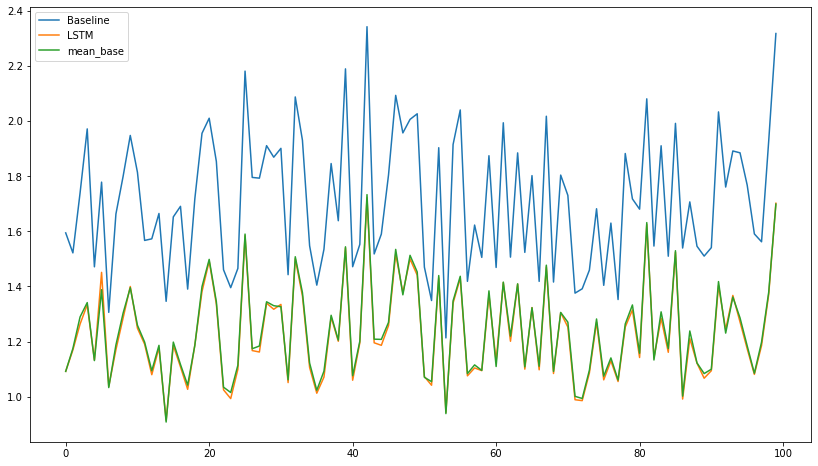

In [287]:
res_df.plot(figsize=(14,8));

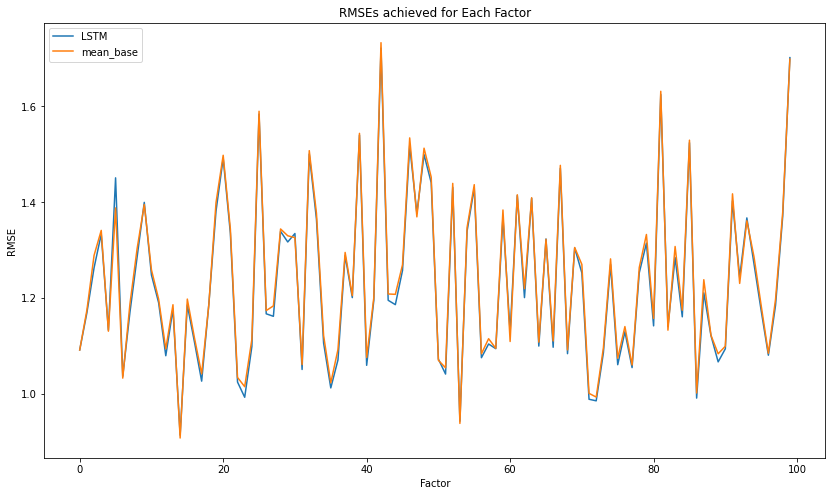

In [332]:
ax = res_df[['LSTM', 'mean_base']].plot(figsize=(14,8), title='RMSEs achieved for Each Factor');
ax.set_xlabel('Factor');
ax.set_ylabel('RMSE');

In [55]:
# Find RMSEs for predictions for a range of days ahead
future = [1, 2, 4, 7, 12, 17, 22, 27]
resf = {}
resfcp = {}
for i in range(100):
    print(i)
    
    X_train, y_train, X_val, y_val, X_test, y_test = split(i)
    
    model = load_model(f'models/model2_{i}.h5')
    
    resf[str(i) +'_lstm'] = {}
    resf[str(i) +'_mean_base'] = {}
    resf[str(i) +'_prev_base'] = {}
    resfcp[str(i) +'_lstm'] = {}
    resfcp[str(i) +'_mean_base'] = {}
    resfcp[str(i) +'_prev_base'] = {}
    
    mean = [np.mean(x) for x in X_test[:80]]
    for f in future:
        Xd = X_test[:80]
        yd = model.predict(Xd)
        yd = np.array(yd).reshape(-1,1, 1)
        for d in range(f):
            yd = model.predict(Xd)
            yd = np.array(yd).reshape(-1,1, 1)
            Xd = np.hstack((Xd, yd))[:,1:,:]

        resf[str(i) + '_prev_base'][f] = MSE(y_test[f:f+79], y_test[f-1:f+78], squared=False)
        resf[str(i) +'_lstm'][f] = MSE(y_test[f-1:f+79], yd.reshape((-1,)), squared=False)
        resf[str(i) + '_mean_base'][f] = MSE(y_test[f-1:f+79], mean, squared=False)
        resfcp[str(i) + '_prev_base'][f] = sum(np.sign(y_test[f:f+79])*np.sign(y_test[f-1:f+78]))
        resfcp[str(i) +'_lstm'][f] = sum(np.sign(y_test[f-1:f+79])*np.sign(yd.reshape((-1,))))
        resfcp[str(i) + '_mean_base'][f] = sum(np.sign(y_test[f-1:f+79])*np.sign(mean))
    

resf = pd.DataFrame(resf)
resfcp = pd.DataFrame(resfcp)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [66]:
resf

,0_lstm,0_mean_base,0_prev_base,1_lstm,1_mean_base,1_prev_base,2_lstm,2_mean_base,2_prev_base,3_lstm,...,96_prev_base,97_lstm,97_mean_base,97_prev_base,98_lstm,98_mean_base,98_prev_base,99_lstm,99_mean_base,99_prev_base
1,1.039930,1.053256,1.765204,1.168522,1.180367,1.452126,1.067222,1.102744,1.78396,1.307856,...,1.660588,1.110170,1.116791,1.431456,1.300904,1.315930,1.824499,1.803385,1.802388,2.296423
2,1.042272,1.055213,1.765204,1.132177,1.148604,1.452126,1.053641,1.098960,1.78396,1.309159,...,1.660588,1.120518,1.134773,1.431456,1.308240,1.334019,1.824499,1.808673,1.818467,2.296423
4,1.065361,1.067565,1.765204,1.118201,1.139771,1.452126,1.058982,1.105125,1.78396,1.297186,...,1.660588,1.123522,1.146676,1.431456,1.320433,1.347102,1.824499,1.818684,1.828490,2.296423
7,1.065979,1.069584,1.765204,1.113821,1.132338,1.452126,1.078482,1.127903,1.78396,1.313319,...,1.660588,1.124182,1.141936,1.431456,1.358637,1.379889,1.824499,1.824566,1.820990,2.296423
12,1.077757,1.089652,1.765204,1.138343,1.156770,1.452126,1.128395,1.173307,1.78396,1.325381,...,1.660588,1.107773,1.100048,1.431456,1.353634,1.358497,1.824499,1.769612,1.738001,2.296423
17,1.120622,1.140065,1.765204,1.159415,1.196490,1.452126,1.150531,1.192052,1.78396,1.314825,...,1.660588,1.066505,1.075242,1.431456,1.381295,1.372208,1.824499,1.737498,1.728103,2.296423
22,1.172442,1.190714,1.765204,1.139045,1.162808,1.452126,1.209095,1.249562,1.78396,1.307651,...,1.660588,1.076024,1.078910,1.431456,1.379627,1.369214,1.824499,1.699454,1.687106,2.296423
27,1.201116,1.205694,1.765204,1.170051,1.172654,1.452126,1.317348,1.337466,1.78396,1.281686,...,1.660588,1.092343,1.101373,1.431456,1.341660,1.347227,1.824499,1.702495,1.717604,2.296423


In [85]:
lstms = [col for col in resf.columns if 'lstm' in col]
means = [col for col in resf.columns if 'mean' in col]

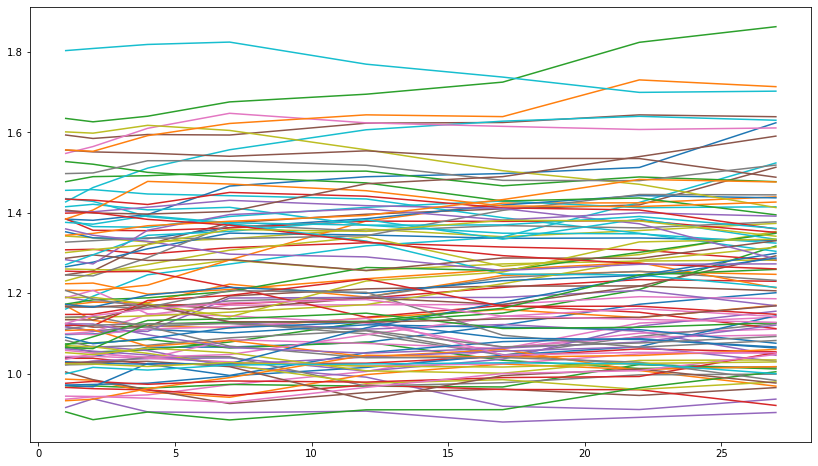

In [312]:
resf[lstms].plot(figsize=(14,8), legend=False);

### Comparison
Now I want to compare these results to the RMSEs I got with the comparison method. However RMSEs produced for different data cannot be directly compared: RMSEs are of the same units as the data that goes into them. I try 2 methods here:   

Method 1:    
Divide each RMSE by the standard deviation of the series that produced it

Method 2:   
I divide the LSTM's RMSEs by the RMSEs found using the mean_baseline

In [69]:
std = {}
for i in range(100):
    X_train, y_train, X_val, y_val, X_test, y_test = split(i)
    std[i] = np.std(y_test)

In [82]:
#results scaled by std of y_test values
resfsc = {}
for i, col in enumerate(resf.columns):
    resfsc[col] = resf[col]/std[i//3]
resfsc = pd.DataFrame(resfsc)    
resfsc


,0_lstm,0_mean_base,0_prev_base,1_lstm,1_mean_base,1_prev_base,2_lstm,2_mean_base,2_prev_base,3_lstm,...,96_prev_base,97_lstm,97_mean_base,97_prev_base,98_lstm,98_mean_base,98_prev_base,99_lstm,99_mean_base,99_prev_base
1,0.965386,0.977757,1.63867,1.005905,1.016101,1.250041,0.849649,0.877929,1.420266,0.980414,...,1.551882,0.938555,0.944152,1.210174,0.948992,0.959953,1.330948,1.072748,1.072155,1.366032
2,0.967560,0.979573,1.63867,0.974618,0.988759,1.250041,0.838836,0.874916,1.420266,0.981391,...,1.551882,0.947302,0.959354,1.210174,0.954344,0.973149,1.330948,1.075894,1.081719,1.366032
4,0.988994,0.991040,1.63867,0.962587,0.981155,1.250041,0.843089,0.879825,1.420266,0.972415,...,1.551882,0.949842,0.969417,1.210174,0.963239,0.982693,1.330948,1.081849,1.087682,1.366032
7,0.989567,0.992914,1.63867,0.958816,0.974757,1.250041,0.858613,0.897959,1.420266,0.984509,...,1.551882,0.950401,0.965410,1.210174,0.991108,1.006611,1.330948,1.085347,1.083220,1.366032
12,1.000501,1.011544,1.63867,0.979925,0.995789,1.250041,0.898350,0.934106,1.420266,0.993551,...,1.551882,0.936528,0.929997,1.210174,0.987458,0.991005,1.330948,1.052658,1.033854,1.366032
17,1.040293,1.058342,1.63867,0.998065,1.029981,1.250041,0.915974,0.949030,1.420266,0.985638,...,1.551882,0.901640,0.909025,1.210174,1.007636,1.001007,1.330948,1.033555,1.027966,1.366032
22,1.088399,1.105361,1.63867,0.980530,1.000986,1.250041,0.962598,0.994816,1.420266,0.980260,...,1.551882,0.909687,0.912127,1.210174,1.006419,0.998824,1.330948,1.010924,1.003579,1.366032
27,1.115017,1.119268,1.63867,1.007221,1.009462,1.250041,1.048782,1.064799,1.420266,0.960796,...,1.551882,0.923483,0.931117,1.210174,0.978723,0.982784,1.330948,1.012733,1.021721,1.366032


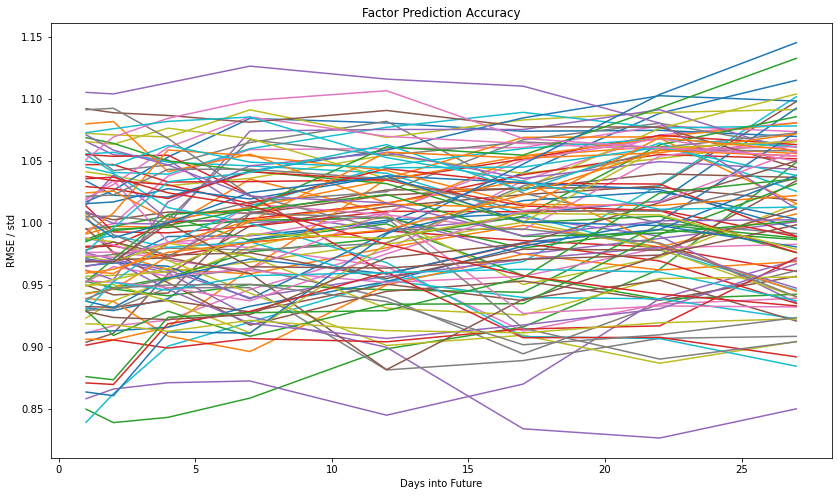

In [323]:
ax = resfsc[lstms].plot(figsize=(14,8), legend=False, title='Factor Prediction Accuracy');
ax.set_xlabel('Days into Future');
ax.set_ylabel('RMSE / std');

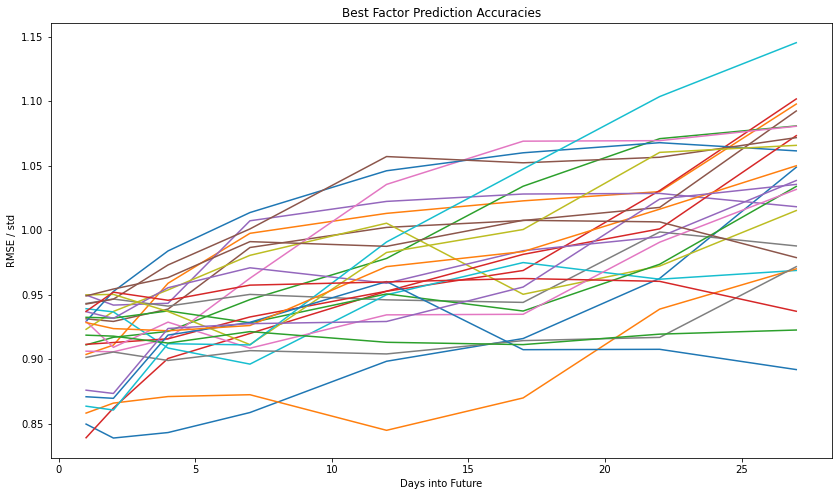

In [326]:
resfsc_lstm = resfsc[lstms].transpose()
ax = resfsc_lstm[(resfsc_lstm[1] < resfsc_lstm[27]) & 
            (resfsc_lstm[1] < 0.95)].transpose().plot(figsize=(14,8), 
                                                      legend=False, 
                                                      title='Best Factor Prediction Accuracies');
ax.set_xlabel('Days into Future');
ax.set_ylabel('RMSE / std');

In [314]:
len(resfsc_lstm[(resfsc_lstm[1] < resfsc_lstm[27]) & (resfsc_lstm[1] < 0.95)])

26

In [213]:
for i in range(100):
    resf[str(i) + '_div'] = resf[str(i) + '_lstm'] / resf[str(i) + '_mean_base']
divs = [col for col in resf.columns if 'div' in col]

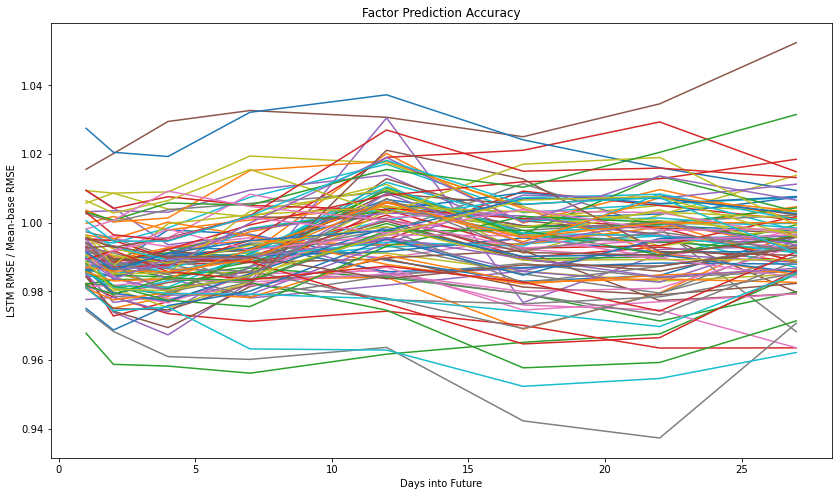

In [330]:
ax = resf[divs].plot(figsize=(14,8), legend=False, title='Factor Prediction Accuracy');
ax.set_xlabel('Days into Future');
ax.set_ylabel('LSTM RMSE / Mean-base RMSE');

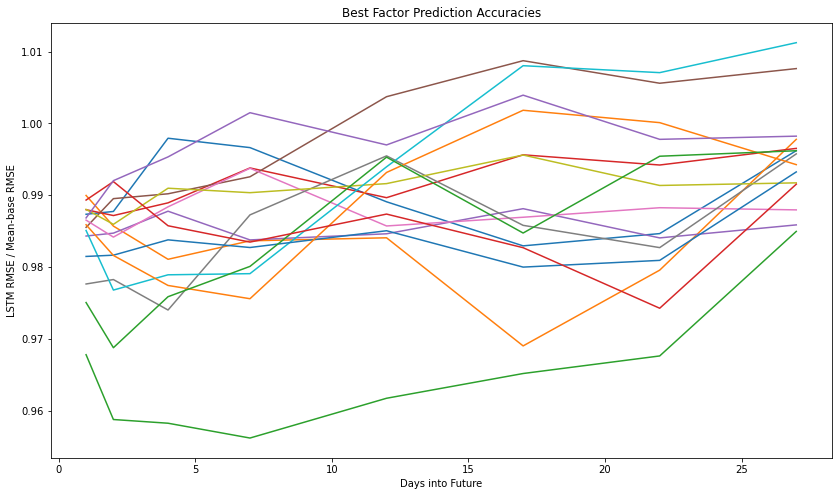

In [331]:
resf_div = resf[divs].transpose()
ax = resf_div[(resf_div[1] < resf_div[27]) & (resf_div[12] < resf_div[27]) 
         & (resf_div[1] < 0.99)].transpose().plot(figsize=(14,8), legend=False, 
                                                  title='Best Factor Prediction Accuracies');
ax.set_xlabel('Days into Future');
ax.set_ylabel('LSTM RMSE / Mean-base RMSE');

In [321]:
len(resf_div[(resf_div[1] < resf_div[27]) & (resf_div[12] < resf_div[27]) & (resf_div[1] < 0.99)])

15

In [93]:
future = [1, 2, 4, 7, 12, 17, 22, 27]
resfr2 = {}
for i in range(100):
    print(i)
    
    X_train, y_train, X_val, y_val, X_test, y_test = split(i)
    
    model = load_model(f'models/model2_{i}.h5')
    
    resfr2[str(i) +'_lstm'] = {}
    resfr2[str(i) +'_mean_base'] = {}
    resfr2[str(i) +'_prev_base'] = {}
    
    mean = [np.mean(x) for x in X_test[:80]]
    
    
    Xd = X_test[:80]
    e=0
    for f in future:
        yd = model.predict(Xd)
        yd = np.array(yd).reshape(-1,1, 1)
        for d in range(e, f):
            yd = model.predict(Xd)
            yd = np.array(yd).reshape(-1,1, 1)
            Xd = np.hstack((Xd, yd))[:,1:,:]
        e=f

        resfr2[str(i) + '_prev_base'] = r2_score(y_test[f:f+79], y_test[f-1:f+78])
        resfr2[str(i) +'_lstm'][f] = r2_score(y_test[f-1:f+79], yd.reshape((-1,)))
        resfr2[str(i) + '_mean_base'][f] = r2_score(y_test[f-1:f+79], mean)

resfr2 = pd.DataFrame(resfr2)
resfr2

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


,0_lstm,0_mean_base,0_prev_base,1_lstm,1_mean_base,1_prev_base,2_lstm,2_mean_base,2_prev_base,3_lstm,...,96_prev_base,97_lstm,97_mean_base,97_prev_base,98_lstm,98_mean_base,98_prev_base,99_lstm,99_mean_base,99_prev_base
1,-0.006497,-0.032458,-1.166477,-0.011864,-0.032482,-0.524915,-0.010492,-0.078880,-0.823728,0.000022,...,-1.152974,-0.025176,-0.037439,-0.719481,0.003340,-0.019817,-0.850702,-0.021478,-0.020349,-0.811519
2,-0.007813,-0.032995,-1.166477,-0.009793,-0.039307,-0.524915,-0.014967,-0.104157,-0.823728,-0.000406,...,-1.152974,-0.019500,-0.045605,-0.719481,0.003259,-0.036410,-0.850702,-0.022729,-0.033835,-0.811519
4,-0.013038,-0.017234,-1.166477,-0.009041,-0.048344,-0.524915,-0.003340,-0.092683,-0.823728,0.000444,...,-1.152974,-0.006532,-0.048446,-0.719481,0.003871,-0.036772,-0.850702,-0.027714,-0.038826,-0.811519
7,-0.015530,-0.022411,-1.166477,-0.009382,-0.043224,-0.524915,0.002111,-0.091441,-0.823728,-0.000559,...,-1.152974,-0.002910,-0.034837,-0.719481,0.003963,-0.027442,-0.850702,-0.030441,-0.026405,-0.811519
12,-0.010108,-0.032528,-1.166477,-0.012958,-0.046019,-0.524915,-0.001449,-0.082754,-0.823728,-0.004918,...,-1.152974,-0.012708,0.001367,-0.719481,0.000119,-0.007079,-0.850702,-0.028649,0.007773,-0.811519
17,-0.007836,-0.043112,-1.166477,-0.003621,-0.068834,-0.524915,-0.005520,-0.079406,-0.823728,-0.001635,...,-1.152974,-0.016004,-0.032717,-0.719481,-0.001330,0.011801,-0.850702,-0.018984,-0.007994,-0.811519
22,-0.016414,-0.048341,-1.166477,-0.001535,-0.043760,-0.524915,-0.000116,-0.068182,-0.823728,-0.000750,...,-1.152974,-0.006448,-0.011854,-0.719481,-0.003963,0.011134,-0.850702,-0.009796,0.004825,-0.811519
27,-0.014440,-0.022188,-1.166477,-0.002215,-0.006679,-0.524915,-0.005770,-0.036724,-0.823728,-0.000070,...,-1.152974,-0.010058,-0.026827,-0.719481,-0.000077,-0.008395,-0.850702,-0.006025,-0.023961,-0.811519


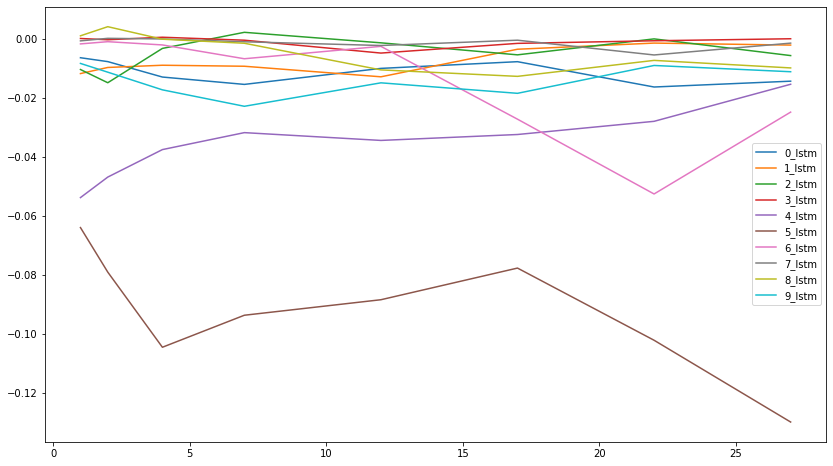

In [96]:
resfr2[lstms[:10]].plot(figsize=(14,8));

In [97]:
resfcp

,0_lstm,0_mean,0_prev_base,1_lstm,1_mean,1_prev_base,2_lstm,2_mean,2_prev_base,3_lstm,...,96_prev_base,97_lstm,97_mean,97_prev_base,98_lstm,98_mean,98_prev_base,99_lstm,99_mean,99_prev_base
1,-8.0,-8.0,3.0,-14.0,0.0,13.0,4.0,-10.0,15.0,8.0,...,-11.0,-6.0,-8.0,5.0,6.0,-2.0,5.0,-4.0,2.0,5.0
2,-10.0,-6.0,3.0,-16.0,-6.0,15.0,4.0,-14.0,17.0,6.0,...,-13.0,-4.0,-12.0,5.0,4.0,-26.0,5.0,-6.0,2.0,5.0
4,-10.0,-6.0,5.0,-16.0,-14.0,15.0,8.0,-14.0,17.0,2.0,...,-13.0,-4.0,-18.0,3.0,8.0,-4.0,7.0,-10.0,-8.0,7.0
7,-4.0,2.0,9.0,-22.0,-6.0,13.0,4.0,-20.0,19.0,0.0,...,-13.0,10.0,-10.0,5.0,8.0,-6.0,5.0,-8.0,-4.0,9.0
12,-4.0,0.0,5.0,-30.0,-12.0,9.0,6.0,-22.0,13.0,-10.0,...,-13.0,2.0,2.0,7.0,4.0,0.0,7.0,-12.0,4.0,7.0
17,-4.0,-12.0,5.0,-24.0,-22.0,11.0,10.0,-22.0,17.0,0.0,...,-15.0,-2.0,10.0,13.0,4.0,10.0,9.0,-8.0,0.0,9.0
22,-8.0,-8.0,3.0,2.0,6.0,15.0,0.0,-14.0,15.0,4.0,...,-11.0,6.0,10.0,13.0,4.0,16.0,15.0,-18.0,-2.0,9.0
27,-6.0,-8.0,-5.0,2.0,10.0,15.0,4.0,-2.0,19.0,6.0,...,-7.0,-2.0,0.0,15.0,0.0,-4.0,15.0,-8.0,-4.0,11.0


### Rebuild
Rebuild the stock value changes using the predictions for the new Day (pu) matrix

In [187]:
future = [1, 2, 4, 7, 12, 17, 22, 27]
reb = {}
for f in future:
    reb[f] = {}
    
for i in range(100):
    X_train, y_train, X_val, y_val, X_test, y_test = split(i)
    model = load_model(f'models/model2_{i}.h5')
    e=1
    Xd = X_test
    yd = model.predict(Xd)
    yd = np.array(yd).reshape(-1,1, 1)
    
    for f in future:
        for d in range(e, f):
            Xd = np.hstack((Xd, yd))[:,1:,:]
            yd = model.predict(Xd)
            yd = np.array(yd).reshape(-1,1, 1)
        e = f
        reb[f][i] = list(model.predict(Xd))

reb = pd.DataFrame(reb)
reb

,1,2,4,7,12,17,22,27
0,"[[-0.055416465], [-0.049472988], [-0.044881783...","[[-0.049483985], [-0.0445757], [-0.04131402], ...","[[-0.040323354], [-0.035292126], [-0.034438], ...","[[-0.028050473], [-0.025227433], [-0.027261518...","[[-0.022205243], [-0.02289941], [-0.017790824]...","[[-0.026246613], [-0.027102172], [-0.01824778]...","[[-0.025863599], [-0.025335137], [-0.020410324...","[[-0.019169383], [-0.018064097], [-0.016343422..."
1,"[[0.00061384495], [-0.0046428493], [-0.0114960...","[[-0.0025532239], [-0.012782013], [-0.01775750...","[[-0.011114664], [-0.028509427], [-0.024219166...","[[-0.017468814], [-0.03167658], [-0.018240687]...","[[-0.0077903555], [-0.0004973165], [0.00127562...","[[0.00048305164], [0.0126087405], [0.00446381]...","[[-0.0007044894], [0.0034900527], [-0.00120415...","[[-0.0038314192], [-0.004889481], [-0.00492389..."
2,"[[0.0082310345], [0.009647847], [0.010961686],...","[[0.008600673], [0.011573496], [0.011743274], ...","[[0.008180814], [0.0149706565], [0.01137209], ...","[[0.005148503], [0.015374653], [0.0074850125],...","[[-0.0015853364], [0.0072405245], [-0.00062339...","[[-0.00650013], [-0.001438071], [-0.00622488],...","[[-0.009132161], [-0.006856964], [-0.009119012...","[[-0.010228567], [-0.009462165], [-0.010283658..."
3,"[[-0.006063104], [-0.001732961], [0.0015634333...","[[-0.0026425566], [0.0033916314], [0.003128360...","[[0.0039815814], [0.011783168], [0.0026968191]...","[[0.008316591], [0.014596621], [0.00075724954]...","[[0.0061979634], [0.0075902767], [0.002393425]...","[[0.004481727], [0.0044932957], [0.0042103915]...","[[0.0044776024], [0.004581787], [0.004486124],...","[[0.0045962846], [0.0047008907], [0.004467251]..."
4,"[[0.017994033], [0.0042283237], [-0.0095668025...","[[0.0075602103], [-0.011871215], [-0.020244125...","[[-0.011284515], [-0.03835673], [-0.029303921]...","[[-0.022748066], [-0.045255564], [-0.021693971...","[[-0.0131172575], [-0.008795328], [-0.00342163...","[[-0.0038638024], [0.0073534213], [-0.00113910...","[[-0.0027426186], [0.0016908497], [-0.00338003...","[[-0.0034516852], [-0.003119667], [-0.00384313..."
...,...,...,...,...,...,...,...,...
95,"[[-0.019834043], [-0.018058682], [-0.015745977...","[[-0.018074688], [-0.015795078], [-0.012598516...","[[-0.013277115], [-0.009755671], [-0.004027608...","[[-0.004512818], [-5.159562e-05], [0.009903679...","[[0.002562244], [0.0055515384], [0.017689161],...","[[-0.0022706087], [-0.0012508727], [0.00709675...","[[-0.009366799], [-0.009148736], [-0.005136837...","[[-0.01351179], [-0.013447679], [-0.011813282]..."
96,"[[0.09708837], [0.06328981], [0.034409776], [0...","[[0.064004175], [0.034748297], [0.013353154], ...","[[0.012092123], [0.0010525726], [-0.0016833341...","[[-0.020320883], [0.0032924386], [0.019161684]...","[[0.022759672], [0.03361867], [0.035187505], [...","[[0.055496484], [0.023285886], [0.008746345], ...","[[0.032533366], [0.01432166], [0.009731833], [...","[[0.014949002], [0.024471385], [0.029890973], ..."
97,"[[0.005600684], [0.0055934037], [0.0022851354]...","[[0.0069483113], [-0.0021141819], [0.013670919...","[[0.008188706], [0.0059121526], [0.02418627], ...","[[0.015991474], [0.0144950785], [0.037164282],...","[[0.030823799], [0.026807437], [0.032415338], ...","[[0.008815119], [-0.00094275177], [-0.00508001...","[[-0.020904051], [-0.016791286], [-0.022274094...","[[-0.011502868], [-0.003906712], [-0.012586351..."
98,"[[-0.003983772], [-0.0015403879], [0.001500305...","[[-0.0018086395], [0.0017999891], [0.00459418]...","[[0.0040041083], [0.0090953335], [0.009900633]...","[[0.011683076], [0.016542088], [0.014123574], ...","[[0.015418257], [0.016658403], [0.014108847], ...","[[0.013151287], [0.011857998], [0.011966055], ...","[[0.011013707], [0.00922456], [0.010611899], [...","[[0.010076746], [0.008774471], [0.010152729], ..."


In [189]:
#create the new testset-pu matrix for each f
reb_dfs = {}
for f in future:
    reb_dfs[f] = {}
    for i in range(100):
        reb_dfs[f][i] = [x[0] for x in reb[1][i]]
        
    reb_dfs[f] = pd.DataFrame(reb_dfs[f])

reb_dfs[1]

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.055416,0.000614,0.008231,-0.006063,0.017994,0.041844,-0.008254,-0.034700,-0.020050,0.002478,...,0.018856,-0.007518,-0.070735,0.009273,0.004946,-0.019834,0.097088,0.005601,-0.003984,-0.002134
1,-0.049473,-0.004643,0.009648,-0.001733,0.004228,0.040434,-0.010929,-0.034961,-0.002915,0.007703,...,0.015363,-0.006745,-0.065996,0.011982,0.003095,-0.018059,0.063290,0.005593,-0.001540,-0.001006
2,-0.044882,-0.011496,0.010962,0.001563,-0.009567,0.039061,-0.013374,-0.035184,0.015883,0.012870,...,0.011581,-0.006845,-0.060664,0.013944,0.002518,-0.015746,0.034410,0.002285,0.001500,0.002677
3,-0.041187,-0.019179,0.010542,0.003566,-0.022440,0.037927,-0.015649,-0.035408,0.026923,0.018597,...,0.007005,-0.006833,-0.054873,0.015402,0.002818,-0.012587,0.013220,0.014977,0.004970,0.009605
4,-0.037280,-0.026444,0.008097,0.005073,-0.036758,0.036874,-0.017719,-0.035626,0.040713,0.023916,...,0.002356,-0.006267,-0.048855,0.016483,0.002374,-0.008609,0.000854,0.024554,0.008863,0.014864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,-0.014351,-0.019056,-0.038577,0.019174,0.022829,-0.023201,0.030384,-0.037288,-0.066868,0.026209,...,-0.025832,-0.007972,-0.069886,-0.007511,-0.000701,0.000460,0.025859,0.035461,0.011726,0.087683
116,0.011467,-0.004645,-0.033870,0.018260,0.026638,-0.022474,0.022388,-0.038386,-0.059228,0.026486,...,-0.030553,-0.007193,-0.072254,-0.004718,0.000020,-0.005622,0.037189,0.034201,0.009161,0.066199
117,0.036361,0.009342,-0.030161,0.017868,0.022280,-0.021057,0.012526,-0.039340,-0.048324,0.026377,...,-0.033991,-0.006426,-0.074894,-0.002712,0.000480,-0.012195,0.048928,0.030225,0.007424,0.040316
118,0.058760,0.022485,-0.028201,0.016017,0.019868,-0.018998,0.001728,-0.039918,-0.036028,0.025180,...,-0.038392,-0.006079,-0.077605,-0.001663,0.002219,-0.018679,0.057568,0.035584,0.006066,0.013541


In [289]:
reb_dfs[27]

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.055416,0.000614,0.008231,-0.006063,0.017994,0.041844,-0.008254,-0.034700,-0.020050,0.002478,...,0.018856,-0.007518,-0.070735,0.009273,0.004946,-0.019834,0.097088,0.005601,-0.003984,-0.002134
1,-0.049473,-0.004643,0.009648,-0.001733,0.004228,0.040434,-0.010929,-0.034961,-0.002915,0.007703,...,0.015363,-0.006745,-0.065996,0.011982,0.003095,-0.018059,0.063290,0.005593,-0.001540,-0.001006
2,-0.044882,-0.011496,0.010962,0.001563,-0.009567,0.039061,-0.013374,-0.035184,0.015883,0.012870,...,0.011581,-0.006845,-0.060664,0.013944,0.002518,-0.015746,0.034410,0.002285,0.001500,0.002677
3,-0.041187,-0.019179,0.010542,0.003566,-0.022440,0.037927,-0.015649,-0.035408,0.026923,0.018597,...,0.007005,-0.006833,-0.054873,0.015402,0.002818,-0.012587,0.013220,0.014977,0.004970,0.009605
4,-0.037280,-0.026444,0.008097,0.005073,-0.036758,0.036874,-0.017719,-0.035626,0.040713,0.023916,...,0.002356,-0.006267,-0.048855,0.016483,0.002374,-0.008609,0.000854,0.024554,0.008863,0.014864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,-0.014351,-0.019056,-0.038577,0.019174,0.022829,-0.023201,0.030384,-0.037288,-0.066868,0.026209,...,-0.025832,-0.007972,-0.069886,-0.007511,-0.000701,0.000460,0.025859,0.035461,0.011726,0.087683
116,0.011467,-0.004645,-0.033870,0.018260,0.026638,-0.022474,0.022388,-0.038386,-0.059228,0.026486,...,-0.030553,-0.007193,-0.072254,-0.004718,0.000020,-0.005622,0.037189,0.034201,0.009161,0.066199
117,0.036361,0.009342,-0.030161,0.017868,0.022280,-0.021057,0.012526,-0.039340,-0.048324,0.026377,...,-0.033991,-0.006426,-0.074894,-0.002712,0.000480,-0.012195,0.048928,0.030225,0.007424,0.040316
118,0.058760,0.022485,-0.028201,0.016017,0.019868,-0.018998,0.001728,-0.039918,-0.036028,0.025180,...,-0.038392,-0.006079,-0.077605,-0.001663,0.002219,-0.018679,0.057568,0.035584,0.006066,0.013541


In [290]:
# reverse the standard scaling
reb_dfsinv = {}
for f in future:
    reb_dfsinv[f] = pd.DataFrame(ss.inverse_transform(reb_dfs[f]))
reb_dfsinv[1]

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.001731,-0.000286,-0.001278,0.001021,-0.004844,0.001425,-0.002621,-0.003103,-0.000610,-0.001226,...,0.008173,-0.005047,-0.003057,0.000244,0.007315,0.000961,0.012340,0.002641,0.007361,0.007739
1,-0.001350,-0.000625,-0.001173,0.001346,-0.005936,0.001339,-0.002805,-0.003122,0.000775,-0.000887,...,0.007930,-0.004992,-0.002750,0.000462,0.007165,0.001077,0.009996,0.002641,0.007531,0.007839
2,-0.001056,-0.001067,-0.001075,0.001594,-0.007030,0.001255,-0.002974,-0.003139,0.002295,-0.000551,...,0.007667,-0.004999,-0.002405,0.000620,0.007119,0.001230,0.007992,0.002397,0.007743,0.008169
3,-0.000819,-0.001563,-0.001106,0.001744,-0.008051,0.001186,-0.003131,-0.003155,0.003187,-0.000179,...,0.007348,-0.004999,-0.002031,0.000738,0.007143,0.001438,0.006522,0.003333,0.007985,0.008789
4,-0.000568,-0.002031,-0.001288,0.001858,-0.009187,0.001122,-0.003273,-0.003172,0.004301,0.000166,...,0.007024,-0.004958,-0.001641,0.000825,0.007107,0.001700,0.005664,0.004039,0.008256,0.009259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.000902,-0.001555,-0.004749,0.002917,-0.004460,-0.002539,0.000044,-0.003295,-0.004394,0.000315,...,0.005060,-0.005080,-0.003002,-0.001107,0.006860,0.002297,0.007399,0.004844,0.008455,0.015773
116,0.002558,-0.000625,-0.004400,0.002848,-0.004158,-0.002495,-0.000508,-0.003377,-0.003776,0.000333,...,0.004731,-0.005024,-0.003155,-0.000882,0.006918,0.001897,0.008185,0.004751,0.008276,0.013851
117,0.004155,0.000277,-0.004124,0.002819,-0.004504,-0.002409,-0.001188,-0.003448,-0.002895,0.000326,...,0.004492,-0.004969,-0.003326,-0.000721,0.006955,0.001464,0.008999,0.004458,0.008155,0.011536
118,0.005591,0.001125,-0.003979,0.002680,-0.004695,-0.002283,-0.001932,-0.003491,-0.001901,0.000248,...,0.004185,-0.004945,-0.003501,-0.000636,0.007095,0.001037,0.009599,0.004853,0.008061,0.009141


In [291]:
svd = dump.load('models/svd/change_svd.p')
svd_model = svd[1]

In [134]:
testset[-20:]

[('2008-10-06', 'VSH', -0.3249530146233077),
 ('2008-10-06', 'VTA', -0.3543721043215058),
 ('2008-10-06', 'VTN', -0.3054827126392441),
 ('2008-10-06', 'VVR', -0.1460859854010192),
 ('2008-10-06', 'WCN', -0.300507513857621),
 ('2008-10-06', 'WEA', -0.4530130649912034),
 ('2008-10-06', 'WEC', -0.6398784247992779),
 ('2008-10-06', 'WFG', 0.0),
 ('2008-10-06', 'WIA', -0.2585877755615016),
 ('2008-10-06', 'WIT', -0.2236246435023583),
 ('2008-10-06', 'WIW', -0.3158012171783566),
 ('2008-10-06', 'WNS', -0.1199999999999992),
 ('2008-10-06', 'WTRG', -0.6002148814695936),
 ('2008-10-06', 'WTS', -0.6017411740239353),
 ('2008-10-06', 'WWE', -0.4540491992267608),
 ('2008-10-06', 'WWW', -0.6716869549857911),
 ('2008-10-06', 'XIN', -0.3165053439150314),
 ('2008-10-06', 'XPO', -0.1580000000000003),
 ('2008-10-06', 'YPF', -0.7431261511555576),
 ('2008-10-06', 'ZTR', -0.4759211387428164)]

In [292]:
pu = svd_model.pu

In [293]:
dates = {}
for f in future:
    dates[f] = days_df.index[-120+f:-40+f]

In [294]:
#only test the SVD on the predicted dates
testsetf = {}
for f in future:
    testsetf[f] = [x for x in testset if x[0] in dates[f]]

In [295]:
#replace the testset dates of the full pu with the testset-pu
puf = {}
for f in future:
    puf[f] = np.array(pd.concat((days_df.iloc[:-120+f], reb_dfsinv[f], days_df.iloc[-40+f:])))

In [296]:
# test the predictions
for f in future:
    print(f, '------------------------------------')
    svd_model.pu = puf[f]
    svd_predict(svd_model, testsetf[f])

1 ------------------------------------
MAE:  0.1559

MAE: 0.15588229675212176
RMSE: 0.22838060599251161
actual mean 0.01355222094745867
pred mean 0.013696978801623943
actual std 0.26797144303801895
pred std 0.11057694511915989
actual max 0.7874387124394104
pred max 0.5917192861598191
actual min -0.7561422527302852
pred min -0.6362535754039044
2 ------------------------------------
MAE:  0.1558

MAE: 0.1558352172417628
RMSE: 0.22830124355902778
actual mean 0.013363880278507748
pred mean 0.013541827434132613
actual std 0.2677037688109057
pred std 0.11023602448193517
actual max 0.7874387124394104
pred max 0.5917192861598191
actual min -0.7561422527302852
pred min -0.6362535754039044
4 ------------------------------------
MAE:  0.1562

MAE: 0.15618596028942566
RMSE: 0.22874427105667813
actual mean 0.012539234150062804
pred mean 0.012836490440286695
actual std 0.26792972508145424
pred std 0.10990555623297919
actual max 0.7874387124394104
pred max 0.5917192861598191
actual min -0.75614225273

Future work:      
 - Try SVD++, takes too long to use now         
 - Repeat the modelling here and for the comparison but instead use the value instead of the change.
 - Perform multivariate LSTM including other data like volume

Future work 2:

For each month work out SVD for a six month rolling window but with the days matrix (pu) fixed from the SVD for all days. The difference in the Stocks matrix (qi) between these and the one for all days shows how the companies have been changing over time - how they react differently to the same stimulus.